## ## GSEA Analysis of Differentially Expressed Genes in Epithelial PLAUR+ vs PLAUR- Cells

In [4]:
import scanpy as sc  # For single-cell RNA-seq data analysis.
import scvi  # For probabilistic modeling of single-cell data.
import numpy as np # For numerical computing.
import pandas as pd  # For data manipulation.   
import gseapy as gp  # For enrichment analysis.
import seaborn as sns  # For data visualization.
import matplotlib.pyplot as plt  # For data visualization.
from scipy.stats import mannwhitneyu  # For computing Mann-Whitney U test.
from scipy.stats import chi2_contingency  # For computing chi-square test.

In [5]:
# Defining the base path to the directory containing single-cell RNA-seq data.
# Make sure to update this path according to your file system.
base_data_path = "/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/data"


In [6]:
# Load the epithelial cell subset AnnData object from an h5ad file
epithelial_cells = sc.read_h5ad(f'{base_data_path}/epith_subset_plaur_status.h5ad')


In [7]:
# Load the saved SCVI model and link it to the loaded epithelial_cells AnnData object
model = scvi.model.SCVI.load(f'{base_data_path}/model_PLAUR_Status.model_3', epithelial_cells)
model

INFO     File /Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/data/model_PLAUR_Status.model_3/model.pt already      
         downloaded                                                                                                


/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/.venv/lib/python3.12/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = tor

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [8]:
# Get the latent representations from the SCVI model and store them in the AnnData object
epithelial_cells.obsm['X_scVI'] = model.get_latent_representation()


In [9]:
# Get the normalized expression values from the SCVI model and store them in a new layer of the AnnData object
epithelial_cells.layers['scvi_normalized'] = model.get_normalized_expression(library_size=1e4)


In [10]:
# Perform differential expression analysis between PLAUR+ and PLAUR- cells using the SCVI model
scvi_de_4 = model.differential_expression(
    idx1=epithelial_cells.obs['PLAUR_Status'] == 'PLAUR+',
    idx2=epithelial_cells.obs['PLAUR_Status'] == 'PLAUR-'
)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# Display the top rows of the differential expression results
scvi_de_4.head()


proba_de  proba_not_de  bayes_factor    scale1        scale2  \
gene_symbol                                                                 
DHRS9          0.9990        0.0010      6.906745  0.000855  2.214015e-05   
IL1RN          0.9978        0.0022      6.117091  0.000226  2.207707e-05   
PLAUR          0.9976        0.0024      6.029880  0.000588  6.557866e-05   
SCEL           0.9976        0.0024      6.029880  0.000086  3.885675e-06   
IL17C          0.9976        0.0024      6.029880  0.000017  5.044241e-07   

             pseudocounts  delta  lfc_mean  lfc_median   lfc_std   lfc_min  \
gene_symbol                                                                  
DHRS9                 0.0   0.25  5.343438    5.209811  2.035658 -1.082397   
IL1RN                 0.0   0.25  3.386201    3.331110  1.185892 -0.671220   
PLAUR                 0.0   0.25  3.108148    3.122125  0.969306 -0.765595   
SCEL                  0.0   0.25  4.559678    4.487777  1.764780 -2.376488   
IL17C                 0.0   0.25  5.009152    5.036017  1.778992 -6.788208   

               lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
gene_symbol                                                           
DHRS9        13.842717   3.978842   0.046362               0.635247   
IL1RN         7.477962   0.771873   0.240713               0.365367   
PLAUR         6.861389   5.261361   0.319312               0.776788   
SCEL         11.261079   0.452872   0.298741               0.269266   
IL17C        11.662915   0.017194   0.000921               0.008597   

             non_zeros_proportion2  raw_normalized_mean1  \
gene_symbol                                                
DHRS9                     0.012281              7.499516   
IL1RN                     0.095794              1.346631   
PLAUR                     0.165183              6.326602   
SCEL                      0.043598              0.862263   
IL17C                     0.000921              0.036152   

             raw_normalized_mean2  is_de_fdr_0.05  
gene_symbol                                        
DHRS9                    0.025013            True  
IL1RN                    0.150446            True  
PLAUR                    0.386652            True  
SCEL                     0.068986            True  
IL17C                    0.000885            True

In [12]:
# Filter for genes that are differentially expressed with FDR < 0.05 and |log fold change| > 0.5
scvi_de_4 = scvi_de_4[(scvi_de_4['is_de_fdr_0.05']) & (abs(scvi_de_4['lfc_mean']) > 0.5)]

# Sort the filtered results by log fold change to see the most upregulated and downregulated genes
scvi_de_4 = scvi_de_4.sort_values('lfc_mean')

# Display the filtered and sorted differential expression results
scvi_de_4.head(20)  # Show the top 20 differentially expressed genes

proba_de  proba_not_de  bayes_factor        scale1    scale2  \
gene_symbol                                                                 
ANGPTL7        0.9880        0.0120      4.410775  1.538610e-07  0.000016   
HBG1           0.9842        0.0158      4.131819  3.311836e-03  0.054829   
CDX2           0.9898        0.0102      4.575114  7.374765e-07  0.000013   
DES            0.9906        0.0094      4.657600  2.515039e-06  0.000087   
KCNK17         0.9886        0.0114      4.462676  5.391807e-07  0.000011   
CCL11          0.9876        0.0124      4.377580  1.911798e-06  0.000078   
HMGCS2         0.9838        0.0162      4.106411  7.879365e-07  0.000039   
AL035670.1     0.9850        0.0150      4.184591  1.021464e-07  0.000003   
RERGL          0.9856        0.0144      4.226022  3.439530e-06  0.000087   
EMILIN3        0.9868        0.0132      4.314250  4.439632e-07  0.000018   
ADH1B          0.9844        0.0156      4.144761  3.020983e-06  0.000167   
GRIN2A         0.9790        0.0210      3.842009  2.868733e-06  0.000036   
GP1BB          0.9882        0.0118      4.427785  7.120423e-06  0.000257   
LINC02206      0.9874        0.0126      4.361378  9.876193e-08  0.000002   
DPT            0.9886        0.0114      4.462676  2.225833e-05  0.000508   
P2RY14         0.9904        0.0096      4.636345  1.222179e-06  0.000028   
OGN            0.9828        0.0172      4.045496  1.211815e-05  0.000373   
TSIX           0.9898        0.0102      4.575114  1.962704e-06  0.000045   
ROBO2          0.9850        0.0150      4.184591  3.913770e-07  0.000015   
NTNG1          0.9890        0.0110      4.498798  4.229365e-07  0.000017   

             pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
gene_symbol                                                                   
ANGPTL7               0.0   0.25 -6.633521   -6.949937  3.465301 -24.177351   
HBG1                  0.0   0.25 -6.399238   -6.897580  8.480985 -39.939037   
CDX2                  0.0   0.25 -5.718355   -6.243910  3.005970 -14.630815   
DES                   0.0   0.25 -5.689224   -5.908727  2.509309 -15.030553   
KCNK17                0.0   0.25 -5.503560   -5.818748  2.940498 -13.385824   
CCL11                 0.0   0.25 -5.351901   -5.755852  2.829547 -15.962883   
HMGCS2                0.0   0.25 -5.283549   -5.880645  3.231505 -18.144123   
AL035670.1            0.0   0.25 -5.253216   -5.653386  3.053937 -26.575909   
RERGL                 0.0   0.25 -5.241611   -5.927894  3.232788 -13.469166   
EMILIN3               0.0   0.25 -5.228518   -5.565794  2.522563 -21.446798   
ADH1B                 0.0   0.25 -5.146192   -5.219225  3.117780 -14.019019   
GRIN2A                0.0   0.25 -5.119517   -5.844910  3.420037 -13.842045   
GP1BB                 0.0   0.25 -5.103303   -5.212158  3.113428 -19.349369   
LINC02206             0.0   0.25 -5.070814   -5.334538  2.928111 -25.394630   
DPT                   0.0   0.25 -5.032781   -5.217724  2.217434 -10.822485   
P2RY14                0.0   0.25 -4.977429   -5.099257  2.226978 -11.927761   
OGN                   0.0   0.25 -4.972469   -5.161688  2.916477 -12.913735   
TSIX                  0.0   0.25 -4.957953   -5.471257  3.186468 -16.304396   
ROBO2                 0.0   0.25 -4.951726   -5.246758  2.995445 -19.309042   
NTNG1                 0.0   0.25 -4.901453   -5.112127  2.716578 -17.542286   

               lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
gene_symbol                                                           
ANGPTL7       8.460634   0.000000   0.162726               0.000000   
HBG1         41.518669   0.011974   0.519804               0.003684   
CDX2          4.855562   0.049125   0.076451               0.026098   
DES           5.335920   0.000614   0.008904               0.000614   
KCNK17        6.729275   0.001228   0.016887               0.000614   
CCL11         6.391426   0.000000   0.003684               0.000000   
HMGCS2     

In [13]:
# Retain genes with a mean normalized expression greater than 0.5 in either PLAUR+ or PLAUR- groups
scvi_de_4 = scvi_de_4[(scvi_de_4['raw_normalized_mean1'] > 0.5) | (scvi_de_4['raw_normalized_mean2'] > 0.5)]

# Display the refined differential expression results
scvi_de_4.head(20)  # Show the top 20 differentially expressed genes after filtering


proba_de  proba_not_de  bayes_factor        scale1    scale2  \
gene_symbol                                                                 
HBG1           0.9842        0.0158      4.131819  3.311836e-03  0.054829   
ADH1B          0.9844        0.0156      4.144761  3.020983e-06  0.000167   
DPT            0.9886        0.0114      4.462676  2.225833e-05  0.000508   
OGN            0.9828        0.0172      4.045496  1.211815e-05  0.000373   
PGC            0.9828        0.0172      4.045496  7.408360e-06  0.000108   
INMT           0.9710        0.0290      3.511030  5.941084e-07  0.000032   
PPY            0.9832        0.0168      4.069433  9.627364e-07  0.000024   
A4GNT          0.9834        0.0166      4.081613  1.489148e-06  0.000030   
GP2            0.9788        0.0212      3.832326  3.154215e-05  0.000223   
CD34           0.9850        0.0150      4.184591  2.415827e-06  0.000061   
TNXB           0.9688        0.0312      3.435640  6.196283e-06  0.000269   
DMBT1          0.9770        0.0230      3.748992  1.915480e-05  0.000293   
SFRP1          0.9628        0.0372      3.253537  5.267986e-06  0.000130   
ITIH5          0.9868        0.0132      4.314250  3.721701e-06  0.000087   
CILP           0.9680        0.0320      3.409496  1.904426e-06  0.000062   
KIAA1324       0.9796        0.0204      3.871609  5.203439e-06  0.000056   
MFAP5          0.9556        0.0444      3.069100  6.199979e-06  0.000191   
PLAC9          0.9732        0.0268      3.592187  1.486432e-05  0.000240   
PRSS2          0.9738        0.0262      3.615446  8.724519e-05  0.000583   
GPC3           0.9682        0.0318      3.415972  3.619704e-06  0.000079   

             pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
gene_symbol                                                                   
HBG1                  0.0   0.25 -6.399238   -6.897580  8.480985 -39.939037   
ADH1B                 0.0   0.25 -5.146192   -5.219225  3.117780 -14.019019   
DPT                   0.0   0.25 -5.032781   -5.217724  2.217434 -10.822485   
OGN                   0.0   0.25 -4.972469   -5.161688  2.916477 -12.913735   
PGC                   0.0   0.25 -4.496308   -4.683257  2.364684 -12.024779   
INMT                  0.0   0.25 -4.443440   -4.378488  3.302249 -16.531017   
PPY                   0.0   0.25 -4.398709   -4.755539  3.477877 -18.180202   
A4GNT                 0.0   0.25 -4.397837   -4.640570  2.583208 -11.029733   
GP2                   0.0   0.25 -4.281901   -4.570000  3.225423 -14.891420   
CD34                  0.0   0.25 -4.080405   -4.327811  2.537418 -11.103357   
TNXB                  0.0   0.25 -4.048958   -3.982328  2.960929 -12.816523   
DMBT1                 0.0   0.25 -3.977268   -4.570783  3.495968 -12.764965   
SFRP1                 0.0   0.25 -3.758383   -3.688036  2.965267 -12.997513   
ITIH5                 0.0   0.25 -3.636552   -3.724367  2.609715 -12.553815   
CILP                  0.0   0.25 -3.616044   -3.513152  3.122723 -15.167681   
KIAA1324              0.0   0.25 -3.590151   -3.880873  1.955808 -16.426165   
MFAP5                 0.0   0.25 -3.468945   -3.239299  3.295144 -13.357850   
PLAC9                 0.0   0.25 -3.464758   -3.475988  2.381102 -20.817272   
PRSS2                 0.0   0.25 -3.463918   -3.763913  2.518090 -10.762926   
GPC3                  0.0   0.25 -3.345758   -3.513385  2.668774 -11.842807   

               lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
gene_symbol                                                           
HBG1         41.518669   0.011974   0.519804               0.003684   
ADH1B         5.438002   0.000307   0.424624               0.000307   
DPT           4.374228   0.013509   0.778631               0.006141   
OGN           7.249313   0.003377   0.730733               0.001842   
PGC           4.960198   0.497697  10.585258               0.025177   
INMT          6.609924   0.001228   0.228739               0.001228   
PPY        

In [14]:
# Save the filtered differential expression results to a CSV file
scvi_de_4.to_csv(f'{base_data_path}/scvi_DEG_results_PLAUR_whole.csv', index=True)


In [15]:
# Extract the list of gene names from the differential expression results DataFrame
gene_list_PLAUR = scvi_de_4.index.tolist()
gene_list_PLAUR[:10]  # Display the first 10 genes in the list


['HBG1', 'ADH1B', 'DPT', 'OGN', 'PGC', 'INMT', 'PPY', 'A4GNT', 'GP2', 'CD34']

In [16]:
# Initialize the new list to store significant genes
significant_genesPLAUR = []

# Iterate through the genes in gene_list_PLAUR
for gene in gene_list_PLAUR:
    # Check if the gene has lfc_mean > 0.5 in scvi_de_4
    if gene in scvi_de_4.index and scvi_de_4.loc[gene, 'lfc_mean'] > 0.5:
        significant_genesPLAUR.append(gene)

# significant_genesPLAUR now contains genes from gene_list_PLAUR with lfc_mean > 0.5 in scvi_de_4


In [17]:
# Print the number of significant genes in the list
print("Number of significant genes:", len(significant_genesPLAUR))

# Print the list of significant genes
print("Significant genes:", significant_genesPLAUR)


Number of significant genes: 401
Significant genes: ['CTSK', 'MT2A', 'SERPINE2', 'IGFBP6', 'UBE2B', 'SPP1', 'RAB9A', 'RAP1B', 'APCS', 'DNAJB6', 'RAB21', 'RAB1A', 'MTPN', 'ATP6V0C', 'CCNG2', 'ARL4A', 'CCN3', 'CASP4', 'RNF141', 'YWHAG', 'AZIN1', 'HNRNPC', 'RALBP1', 'JOSD1', 'ZNF267', 'PTPN2', 'HMGB2', 'SEC23A', 'SIAH1', 'AGFG1', 'MAP1LC3B', 'IAPP', 'CARD19', 'HBG2', 'PPP2R2A', 'PAK2', 'YPEL5', 'TUBA4A', 'EFHD2', 'ARPC5', 'LACTB', 'SMS', 'TPM4', 'ITPKC', 'THBS1', 'BLVRB', 'LPIN2', 'SLC16A4', 'SEMA3C', 'OXSR1', 'UBE2H', 'REL', 'BFAR', 'CD109', 'CLDND1', 'RALB', 'OSER1', 'FXYD5', 'CDKN1A', 'H3F3B', 'CDV3', 'TRIB1', 'COLGALT1', 'SMG7', 'RFFL', 'PLEKHB2', 'CAST', 'YWHAZ', 'PFKP', 'IFRD1', 'CTNNAL1', 'TMSB10', 'HIST3H2A', 'ARL6IP1', 'CD44', 'PLK3', 'SERP1', 'NOP10', 'OSTF1', 'LGALS3', 'LDHA', 'SMIM6', 'PPDPF', 'NRBF2', 'IGLC2', 'RBCK1', 'CAV1', 'PPP1R3B', 'GPD2', 'KCTD9', 'AGTRAP', 'ITGB1', 'VAPA', 'YOD1', 'ARRDC3', 'ARPC3', 'METRNL', 'PATL1', 'CD9', 'ARRDC4', 'IFI6', 'ZBTB43', 'PPP1R15A', 'BR

In [18]:
# Initialize a list to store significant genes based on the criteria
significant_genesPLAUR = []

# Iterate through each gene in the gene list
for gene in gene_list_PLAUR:
    # Check if the gene exists in scvi_de_4 and has a log fold change greater than 0.5
    if gene in scvi_de_4.index and scvi_de_4.loc[gene, 'lfc_mean'] > 0.5:
        significant_genesPLAUR.append(gene)  # Add gene to the list if criteria are met


In [19]:
# Define a list of gene set libraries to use for enrichment analysis
gene_sets = [
    'MSigDB_Hallmark_2020',       # Hallmark pathways from MSigDB (2020)
    'KEGG_2021_Human',            # KEGG pathways for humans (2021)
    'WikiPathway_2023_Human',     # WikiPathways for humans (2023)
    'GO_Biological_Process_2023'  # GO biological processes (2023)
]


In [20]:
import importlib  # Importing the importlib module to reload modules
import utilities  # Importing the custom 'utilities' module

# Reloads the 'utilities' module to reflect any changes made to the module
importlib.reload(utilities)

from utilities import perform_gsea_and_plot

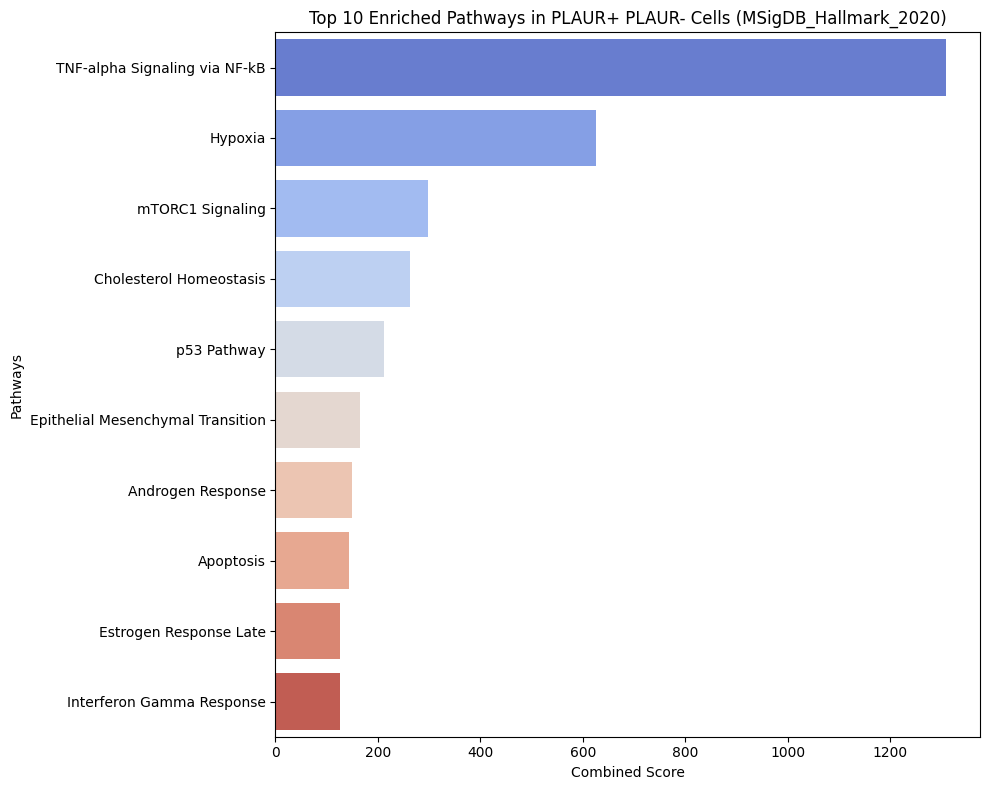

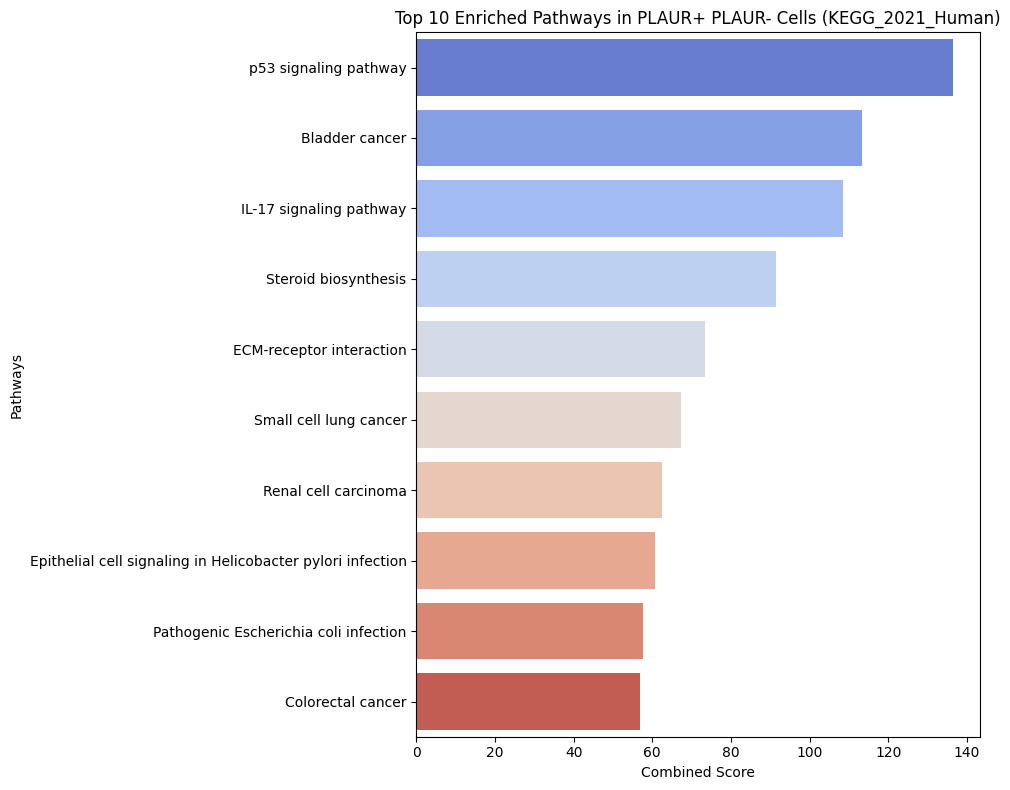

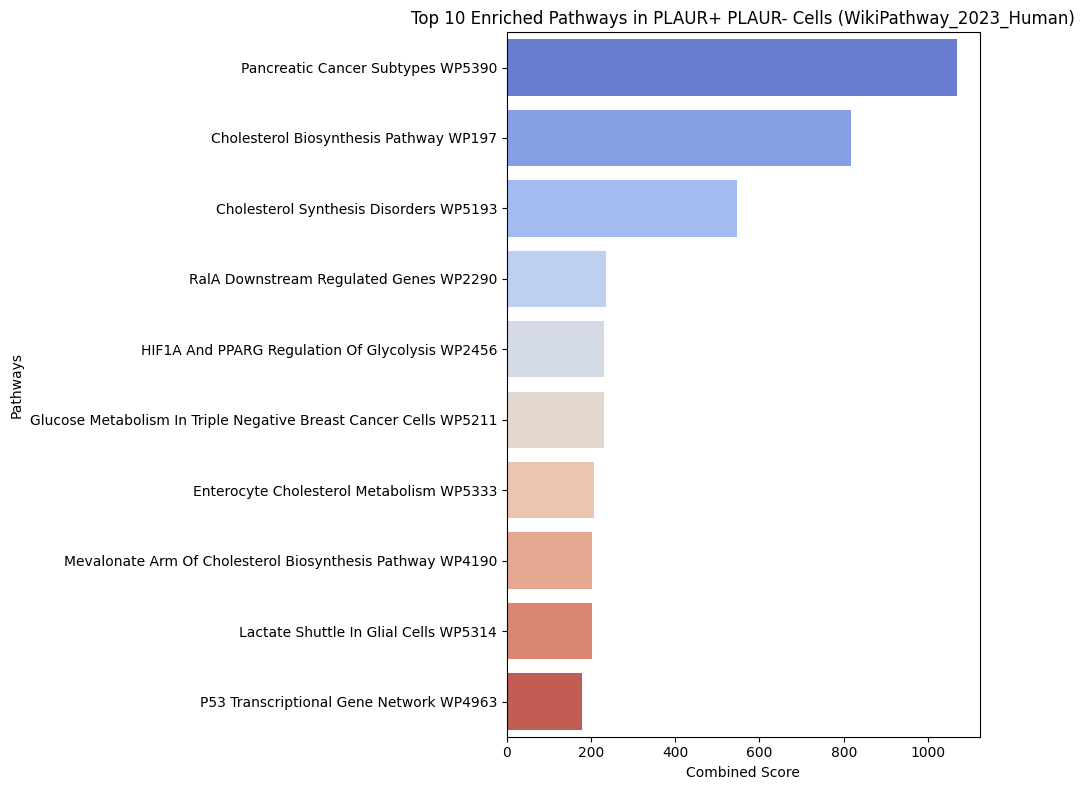

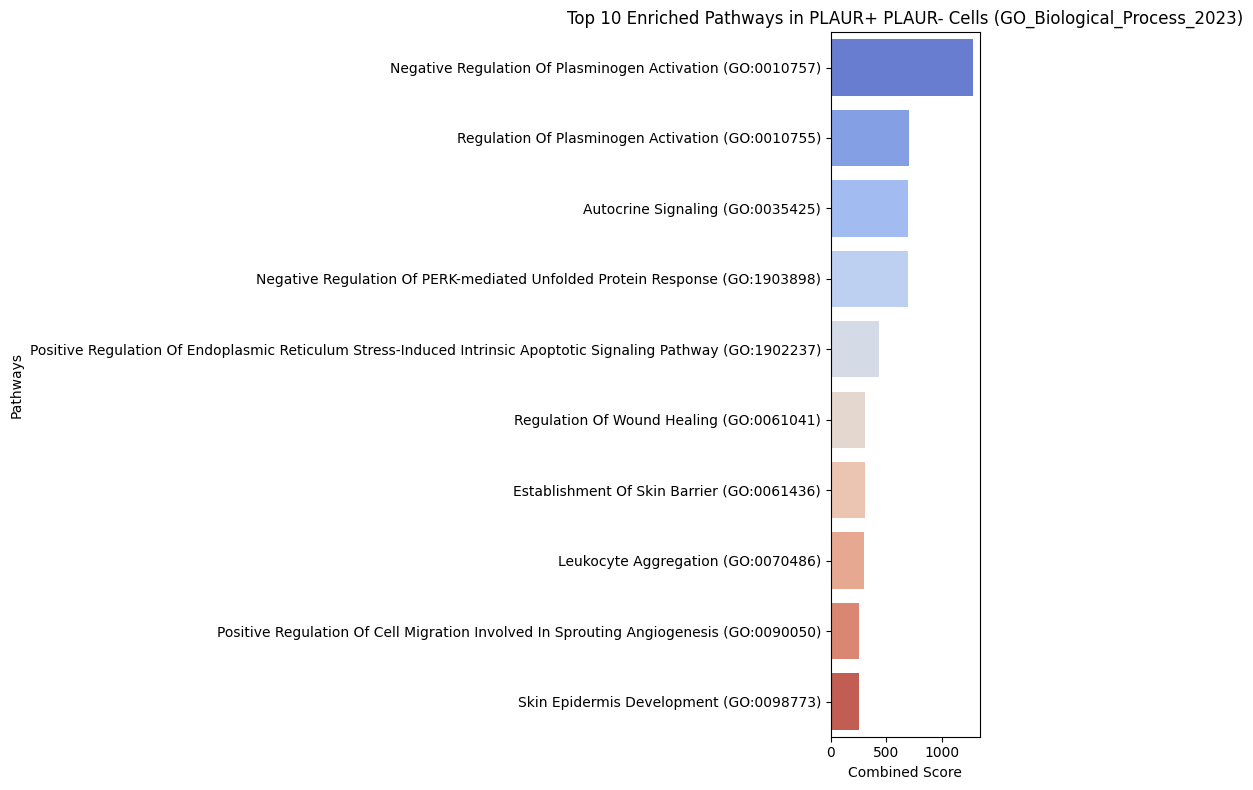

In [21]:
# Run GSEA and plot the results for significant_genesPLAUR with the specified gene sets
perform_gsea_and_plot(significant_genesPLAUR, 'PLAUR+ PLAUR-',gene_sets)

In [22]:
# Initialize the new list to store significantly downregulated genes
significant_genesPLAUR_down = []

# Iterate through the genes in gene_list_PLAUR
for gene in gene_list_PLAUR:
    # Check if the gene is in scvi_de_4 and has an lfc_mean < -0.5
    if gene in scvi_de_4.index and scvi_de_4.loc[gene, 'lfc_mean'] < -0.5:
        significant_genesPLAUR_down.append(gene)  # Add gene to the list if it meets criteria

# significant_genesPLAUR_down now contains genes from gene_list_PLAUR with lfc_mean < -0.5 in scvi_de_4


In [23]:
# Print the number of significant downregulated genes
print("Number of significant downregulated genes:", len(significant_genesPLAUR_down))

# Print the list of significant downregulated genes
print("Significant downregulated genes:", significant_genesPLAUR_down)


Number of significant downregulated genes: 395
Significant downregulated genes: ['HBG1', 'ADH1B', 'DPT', 'OGN', 'PGC', 'INMT', 'PPY', 'A4GNT', 'GP2', 'CD34', 'TNXB', 'DMBT1', 'SFRP1', 'ITIH5', 'CILP', 'KIAA1324', 'MFAP5', 'PLAC9', 'PRSS2', 'GPC3', 'PIK3C2G', 'SCTR', 'SLIT3', 'CDCA7', 'APOA4', 'SULT1C2', 'ALDOB', 'PPP1R1B', 'APOC3', 'ELN', 'FBLN5', 'ONECUT3', 'SMOC2', 'PRSS1', 'GSTM3', 'ONECUT2', 'PDGFRA', 'SCN7A', 'PRELP', 'ABCA8', 'LHFPL6', 'DCN', 'ZNF302', 'NFIA', 'ABCA6', 'PKDCC', 'PLA2G2A', 'APOA1', 'GPM6B', 'CLPS', 'FBLN2', 'PLEKHS1', 'HNF1A-AS1', 'MXRA8', 'MYL9', 'APOD', 'MT1M', 'ANK3', 'LTBP4', 'SOD3', 'PBX1', 'ARFGEF3', 'LINC02532', 'FXYD1', 'LRIG3', 'SCARA5', 'SRPX', 'NKX6-2', 'MFAP4', 'LTBP1', 'ZBTB16', 'NR2F2', 'COL18A1', 'LAMA2', 'SPARCL1', 'CTSF', 'ASPN', 'AEBP1', 'MRC2', 'NEXN', 'CFD', 'MEIS2', 'HBA1', 'NEGR1', 'CHRDL1', 'MEIS1', 'PLP1', 'NDRG2', 'XIST', 'C1orf21', 'LUM', 'FMOD', 'MATN2', 'IGFBP5', 'FHL1', 'CLDN2', 'MUC3A', 'HTRA1', 'FBLN1', 'THY1', 'CXCL12', 'RARRES2', '

## Quantile-Based Differential Expression Analysis of PLAUR+ vs PLAUR- Cells Using Trained SCVI Model (90th vs 10th Percentile)

In [24]:
# Extract the normalized expression values for the PLAUR gene from the SCVI-normalized layer in the epithelial cells AnnData object
plaured_expr = epithelial_cells[:, 'PLAUR'].layers['scvi_normalized']


In [25]:
# Check if the PLAUR expression data is a sparse matrix and convert it to a dense array if necessary
if not isinstance(plaured_expr, np.ndarray):
    plaured_expr = plaured_expr.toarray().flatten()  # Convert sparse matrix to dense array and flatten
else:
    plaured_expr = plaured_expr.flatten()  # Flatten if already dense


In [26]:
# Calculate the 90th and 10th percentiles of the PLAUR expression data
quantile_90 = np.percentile(plaured_expr, 90)
quantile_10 = np.percentile(plaured_expr, 10)


In [27]:
# Subset the epithelial_cells AnnData object based on high and low PLAUR expression
high_plaured_cells = epithelial_cells[plaured_expr >= quantile_90]  # Cells with PLAUR expression in the top 90th percentile
low_plaured_cells = epithelial_cells[plaured_expr <= quantile_10]   # Cells with PLAUR expression in the bottom 10th percentile


In [28]:
# Assign PLAUR expression status to each cell based on whether it falls into high, low, or intermediate categories
epithelial_cells.obs['PLAUR_Status'] = np.where(
    epithelial_cells.obs_names.isin(high_plaured_cells.obs_names), 'High_PLAUR',
    np.where(epithelial_cells.obs_names.isin(low_plaured_cells.obs_names), 'Low_PLAUR', 'Intermediate')
)


In [29]:
# Perform differential expression analysis between High_PLAUR and Low_PLAUR cells using the SCVI model
de_results = model.differential_expression(
    groupby="PLAUR_Status",   # Group cells by PLAUR_Status
    group1="High_PLAUR",      # Define group1 as High PLAUR cells
    group2="Low_PLAUR",       # Define group2 as Low PLAUR cells
    mode="change",            # Use log fold change mode for DE analysis
    delta=0.5                 # Set log fold change threshold at 0.5
)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
# Sort the differential expression results by log fold change (lfc_mean) in descending order
de_results_df = de_results.sort_values(by="lfc_mean", ascending=False)


In [31]:
# Identify upregulated genes in High_PLAUR cells with a log fold change > 0.5 and probability of differential expression > 0.9
upregulated_genes_high_plaured = de_results_df[(de_results_df['lfc_mean'] > 0.5) & (de_results_df['proba_de'] > 0.9)].index.tolist()


In [32]:
# Define a list of gene set libraries to use for enrichment analysis
gene_sets = [
    'MSigDB_Hallmark_2020',       # Hallmark pathways from MSigDB (2020)
    'KEGG_2021_Human',            # KEGG pathways for humans (2021)
    'WikiPathway_2023_Human',     # WikiPathways for humans (2023)
    'GO_Biological_Process_2023'  # Gene Ontology biological processes (2023)
]


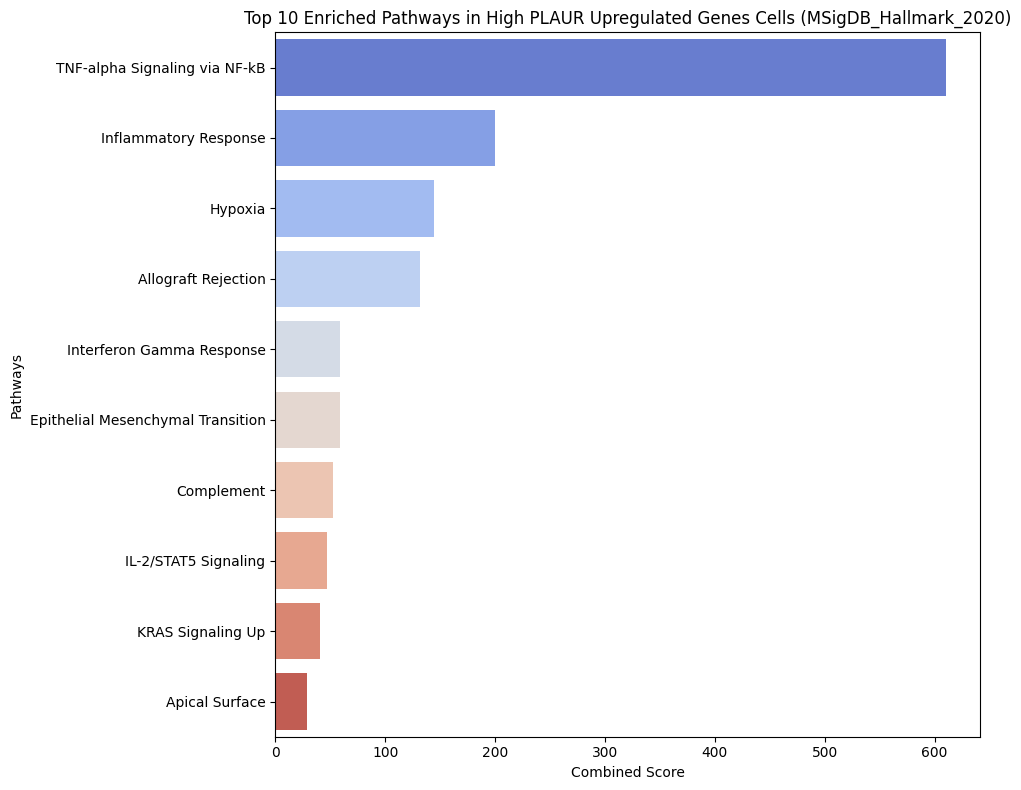

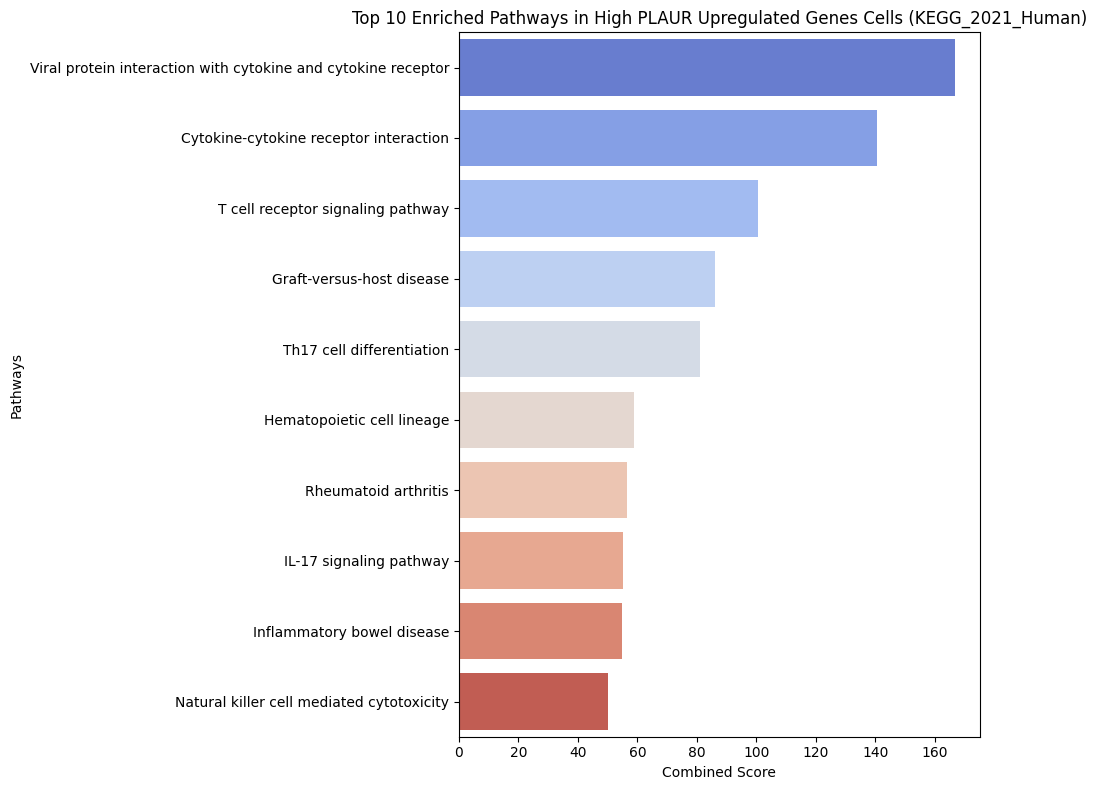

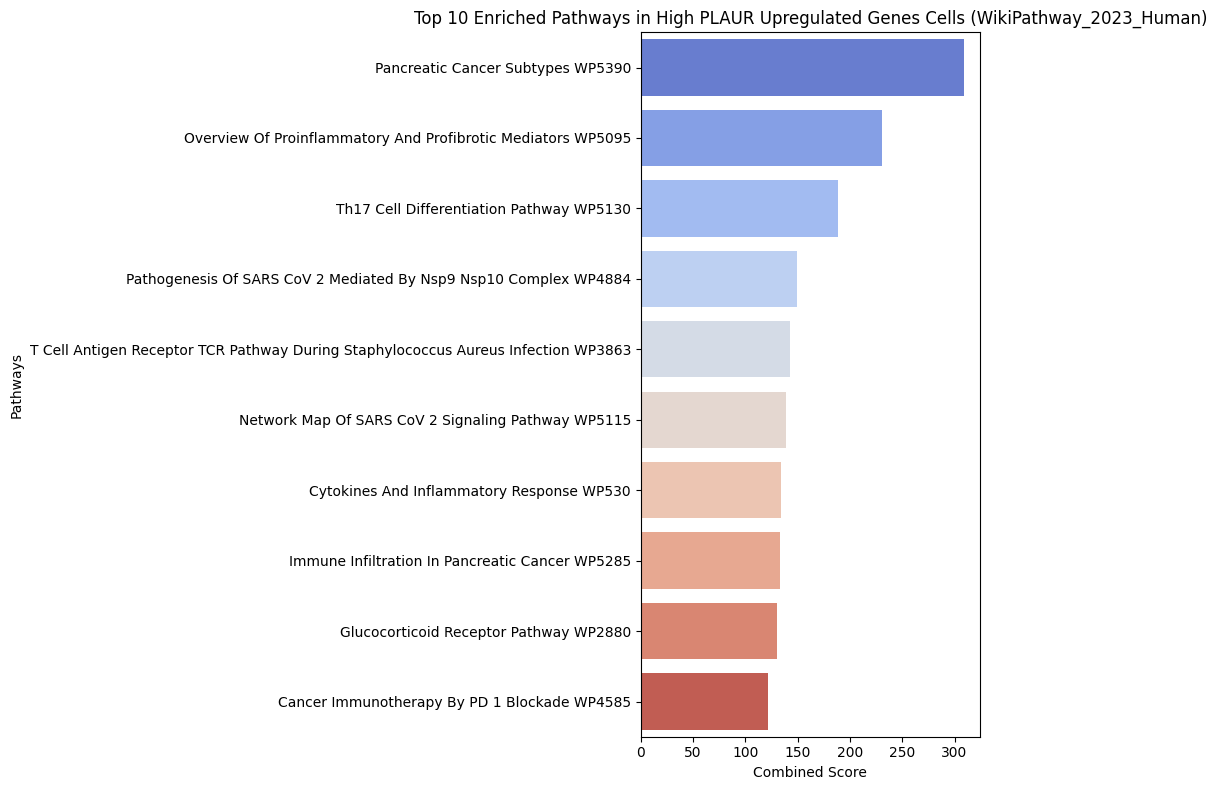

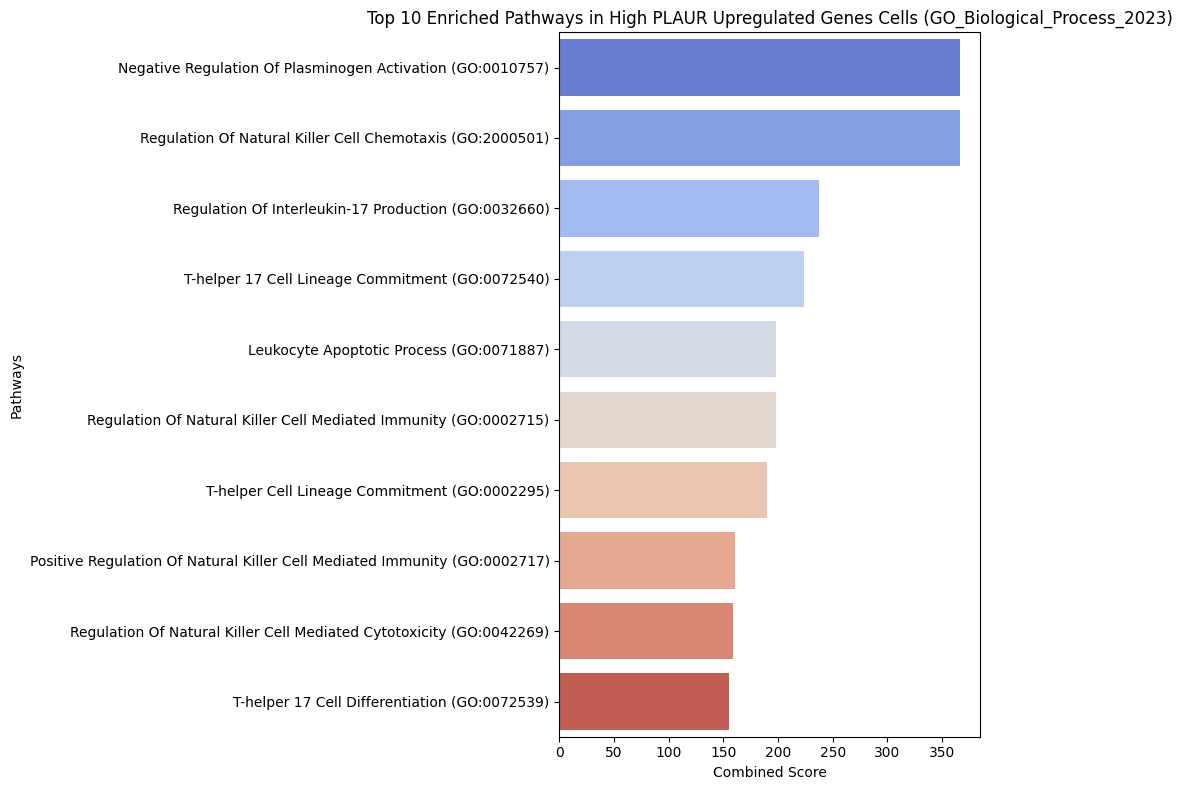

In [33]:
# Run GSEA and plot results for upregulated genes in High PLAUR cells
perform_gsea_and_plot(upregulated_genes_high_plaured, 'High PLAUR Upregulated Genes', gene_sets)

In [34]:
# Define masks for cells in the 90th and 10th quantiles of PLAUR expression
high_plaured_mask = plaured_expr >= quantile_90  # Mask for high PLAUR cells (90th percentile)
low_plaured_mask = plaured_expr <= quantile_10   # Mask for low PLAUR cells (10th percentile)

In [35]:
# Determine the number of cells in the 90th and 10th quantiles based on PLAUR expression
num_high_plaured_cells = np.sum(high_plaured_mask)  # Number of cells in the 90th percentile (high PLAUR)
num_low_plaured_cells = np.sum(low_plaured_mask)    # Number of cells in the 10th percentile (low PLAUR)


In [36]:

print("Number of High PLAUR cells (90th percentile):", num_high_plaured_cells)
print("Number of Low PLAUR cells (10th percentile):", num_low_plaured_cells)

Number of High PLAUR cells (90th percentile): 3257
Number of Low PLAUR cells (10th percentile): 3257


In [37]:
# Extract the normalized expression values for the PLAUR gene from the scvi_normalized layer
plaured_expr = epithelial_cells[:, 'PLAUR'].layers['scvi_normalized']


In [38]:
# Convert sparse matrix to dense array if necessary
if not isinstance(plaured_expr, np.ndarray):
    plaured_expr = plaured_expr.toarray().flatten()  # Convert to dense array and flatten
else:
    plaured_expr = plaured_expr.flatten()  # Flatten if already dense

In [39]:
# Calculate the 90th and 10th percentiles of PLAUR expression
quantile_90 = np.percentile(plaured_expr, 90)
quantile_10 = np.percentile(plaured_expr, 10)


In [40]:
# Subset the epithelial_cells AnnData object for cells with high and low PLAUR expression
high_plaured_cells = epithelial_cells[plaured_expr >= quantile_90]  # Cells with PLAUR expression in the top 90th percentile
low_plaured_cells = epithelial_cells[plaured_expr <= quantile_10]   # Cells with PLAUR expression in the bottom 10th percentile


In [41]:
# Label cells in the AnnData object based on PLAUR expression quantiles
epithelial_cells.obs['PLAUR_Status'] = np.where(
    epithelial_cells.obs_names.isin(high_plaured_cells.obs_names), 'High_PLAUR',
    np.where(epithelial_cells.obs_names.isin(low_plaured_cells.obs_names), 'Low_PLAUR', 'Intermediate')
)


In [42]:
# Perform differential expression analysis between High_PLAUR and Low_PLAUR cells
de_results = model.differential_expression(
    groupby="PLAUR_Status",  # Group cells by PLAUR_Status
    group1="High_PLAUR",     # Define High PLAUR cells as group1
    group2="Low_PLAUR",      # Define Low PLAUR cells as group2
    mode="change",           # Use log fold change mode for DE analysis
    delta=0.5                # Set log fold change threshold at 0.5
)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
# Sort the differential expression results by log fold change in descending order
de_results_df = de_results.sort_values(by="lfc_mean", ascending=False)


In [44]:
# Identify downregulated genes in High_PLAUR cells
# Criteria: lfc_mean < -0.5 and proba_de > 0.9
downregulated_genes_high_plaured = de_results_df[(de_results_df['lfc_mean'] < -0.5) & (de_results_df['proba_de'] > 0.9)].index.tolist()


In [45]:
# Define gene sets for enrichment analysis
gene_sets = [
    'MSigDB_Hallmark_2020',       # Hallmark pathways from MSigDB (2020)
    'KEGG_2021_Human',            # KEGG pathways for humans (2021)
    'WikiPathway_2023_Human',     # WikiPathways for humans (2023)
    'GO_Biological_Process_2023'  # Gene Ontology biological processes (2023)
]


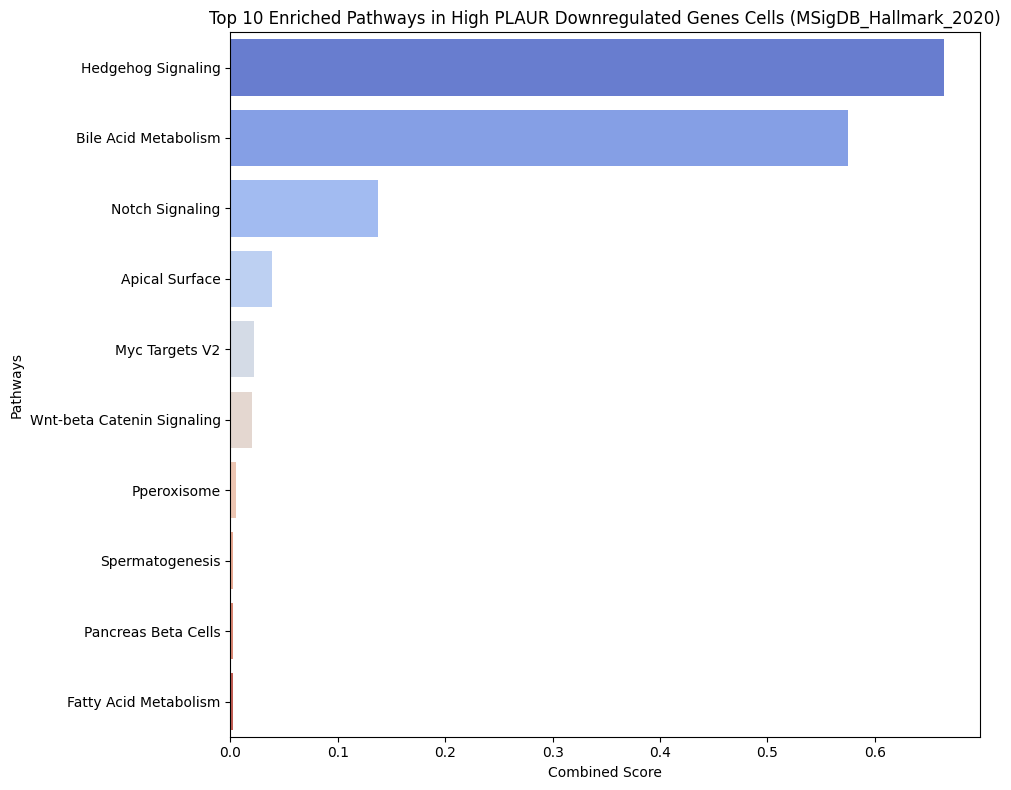

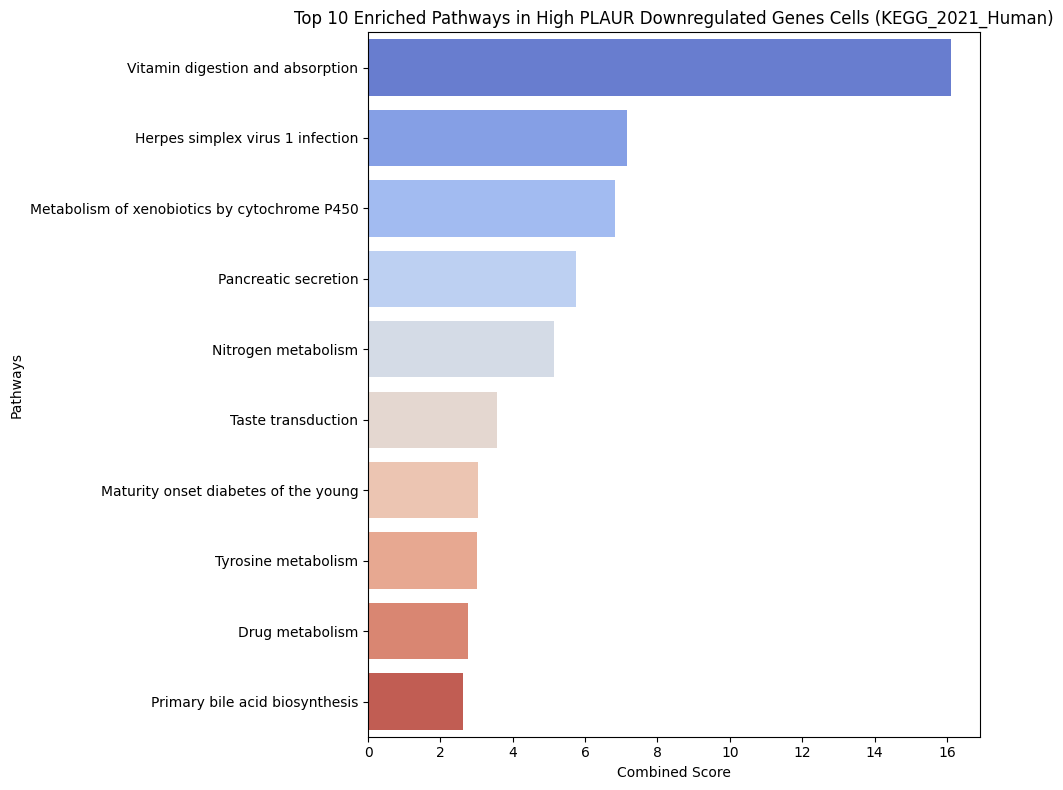

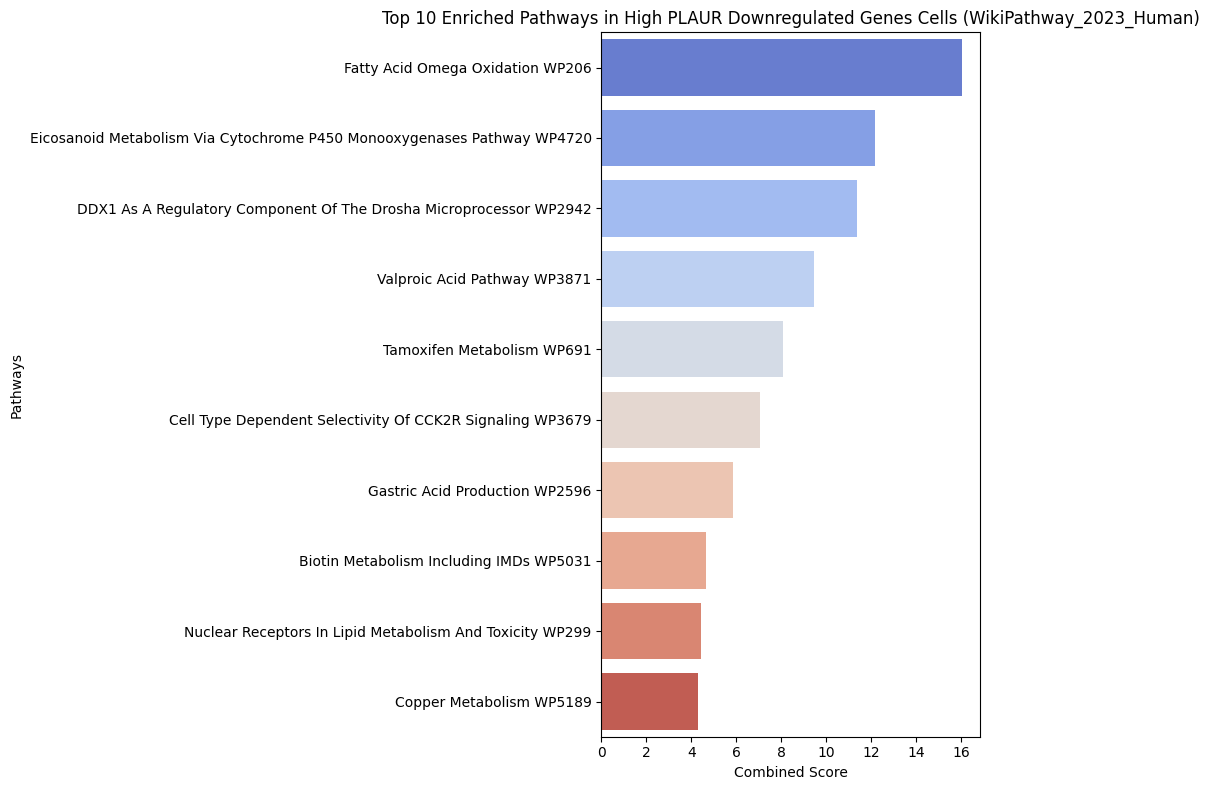

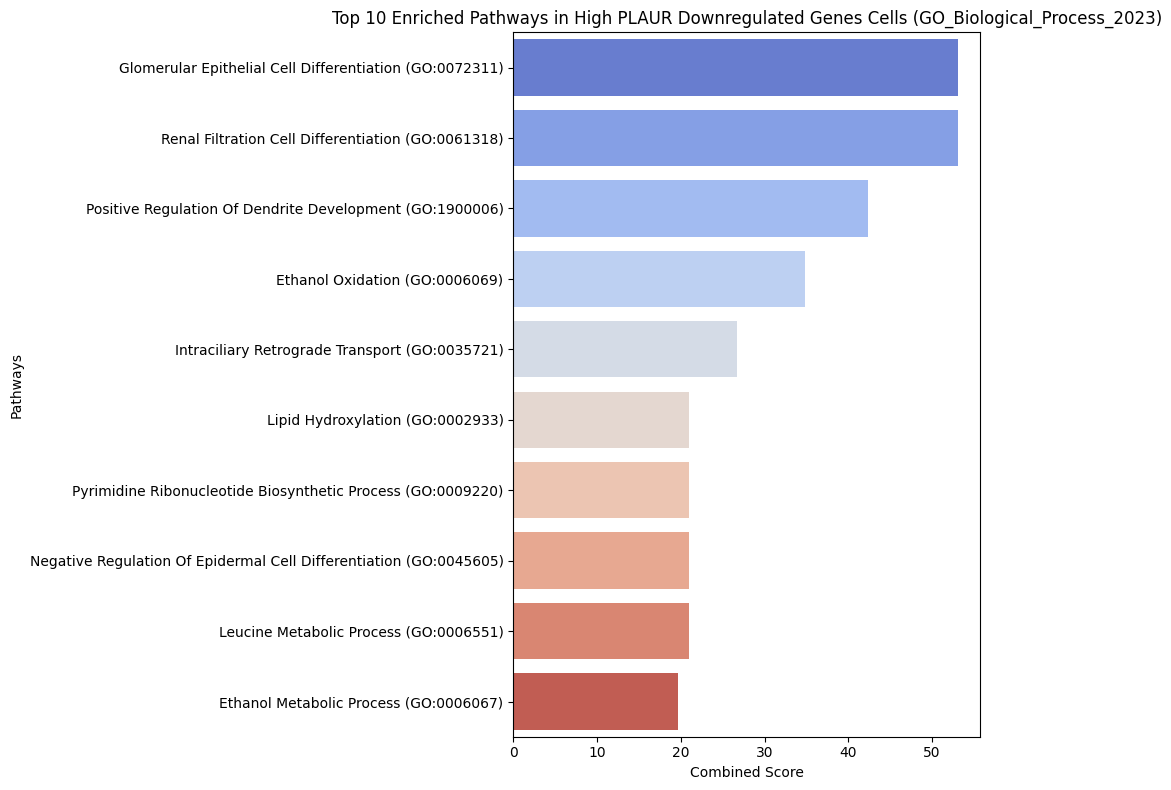

In [46]:
# Run GSEA and plot results for downregulated genes in High PLAUR cells
perform_gsea_and_plot(downregulated_genes_high_plaured,'High PLAUR Downregulated Genes', gene_sets)


In [47]:
# Print specified percentile values for PLAUR expression
for percentile in [10, 25, 50, 75, 90]:
    value = np.percentile(plaured_expr, percentile)  # Calculate the percentile on PLAUR expression
    print(f"{percentile}th percentile of PLAUR expression: {value}")


10th percentile of PLAUR expression: 0.6695331871509552
25th percentile of PLAUR expression: 0.9104698598384857
50th percentile of PLAUR expression: 1.3234627842903137
75th percentile of PLAUR expression: 2.358331024646759
90th percentile of PLAUR expression: 3.991670513153075


In [48]:
# Define high and low thresholds for PLAUR expression
high_threshold = np.percentile(plaured_expr, 90)  # 90th percentile for high expression
low_threshold = np.percentile(plaured_expr, 10)   # 10th percentile for low expression


In [49]:
# Subset cells based on high and low PLAUR expression thresholds
high_PLAUR_cells = epithelial_cells[plaured_expr > high_threshold]  # Cells with PLAUR expression above the 90th percentile
low_PLAUR_cells = epithelial_cells[plaured_expr < low_threshold]    # Cells with PLAUR expression below the 10th percentile

# Print the number of cells in each category
print(f"Number of high PLAUR expressing cells: {high_PLAUR_cells.shape[0]}")
print(f"Number of low PLAUR expressing cells: {low_PLAUR_cells.shape[0]}")


Number of high PLAUR expressing cells: 3257
Number of low PLAUR expressing cells: 3257


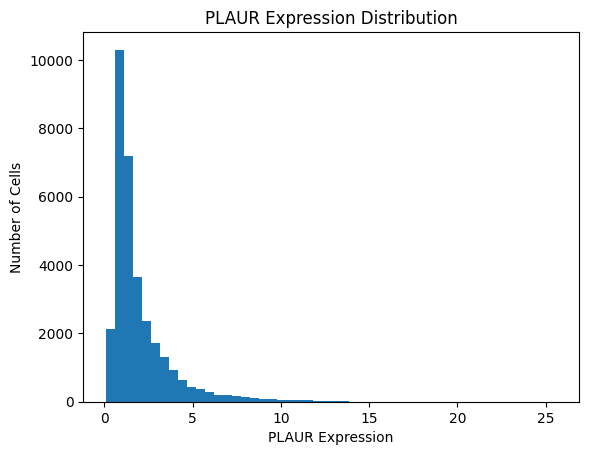

In [50]:
# Visualize the distribution of PLAUR expression
plt.hist(plaured_expr, bins=50)
plt.title('PLAUR Expression Distribution')
plt.xlabel('PLAUR Expression')
plt.ylabel('Number of Cells')
plt.show()

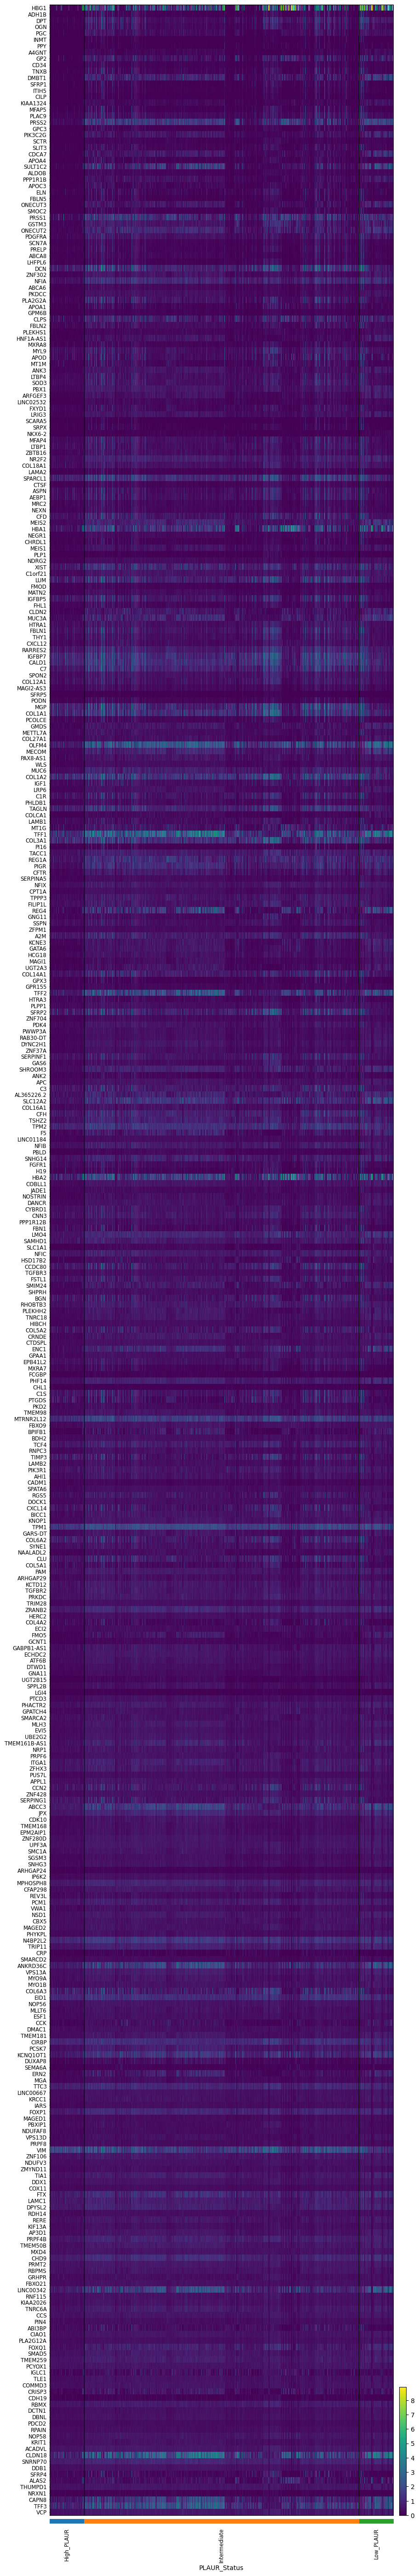

In [51]:
# Plot a heatmap of significant downregulated genes in PLAUR_Status groups
sc.pl.heatmap(
    epithelial_cells, 
    var_names=significant_genesPLAUR_down,  # List of downregulated genes to plot
    groupby='PLAUR_Status',                 # Group cells by PLAUR_Status
    swap_axes=True,                         # Swap axes to show genes on the y-axis
    layer='scvi_normalized',                # Use SCVI-normalized layer for expression values
    log=True,                               # Log-transform values for better visualization
    show_gene_labels=True                   # Display gene labels on the heatmap
)


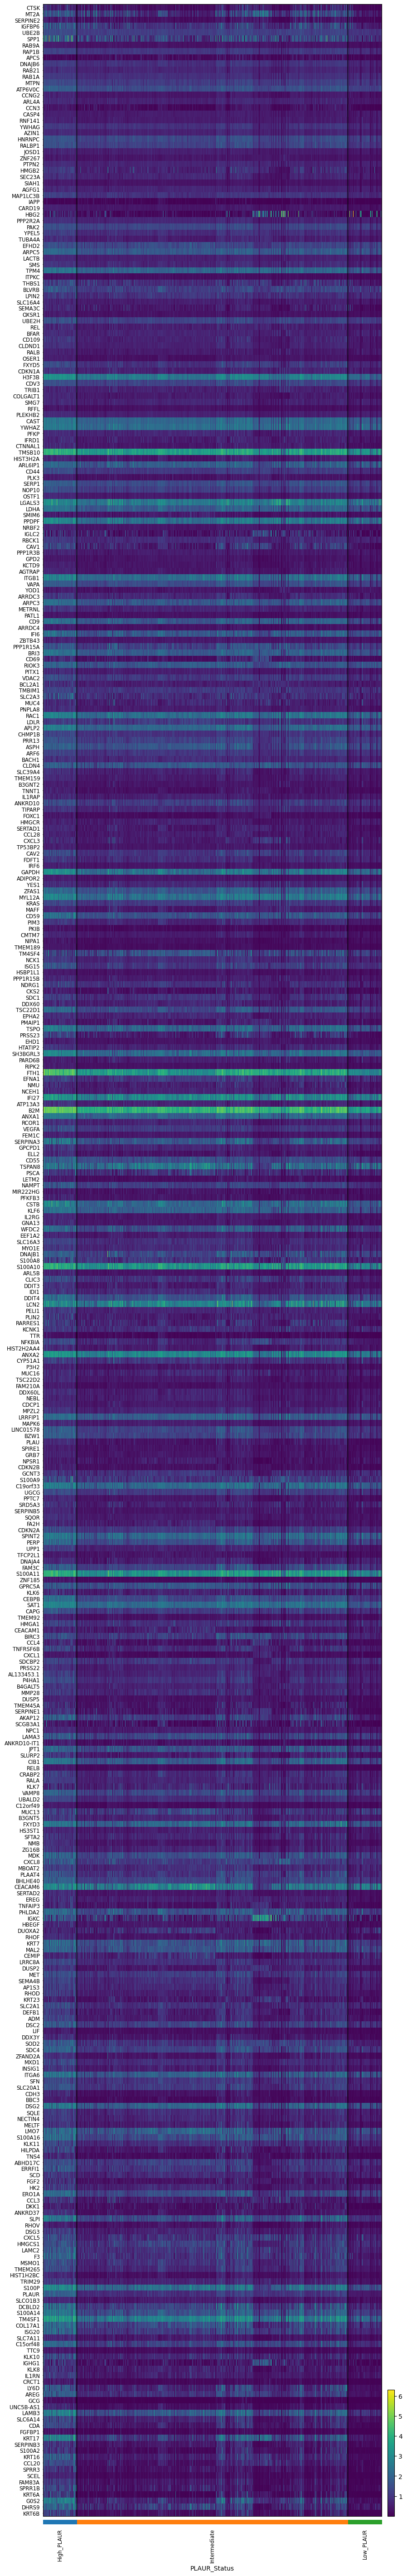

In [52]:
# Plot a heatmap of significant genes across PLAUR_Status groups
sc.pl.heatmap(
    epithelial_cells, 
    var_names=significant_genesPLAUR,      # List of significant genes to plot
    groupby='PLAUR_Status',                # Group cells by PLAUR_Status (e.g., High_PLAUR, Low_PLAUR)
    swap_axes=True,                        # Display genes on the y-axis for better readability
    layer='scvi_normalized',               # Use SCVI-normalized layer for expression values
    log=True,                              # Log-transform values for clearer visualization
    show_gene_labels=True                  # Show gene labels on the heatmap
)


In [53]:
# Assign significant_genesPLAUR to gene_list
gene_list = significant_genesPLAUR


In [54]:
# Filter gene_list to retain only genes available in epithelial_cells
available_genes = [gene for gene in gene_list if gene in epithelial_cells.var_names]


In [55]:
# Extract the scvi-normalized expression data for available genes and convert to DataFrame
expression_data = epithelial_cells[:, available_genes].to_df(layer='scvi_normalized')


In [56]:
# Add PLAUR_Status as a column in the expression_data DataFrame
expression_data['PLAUR_Status'] = epithelial_cells.obs['PLAUR_Status'].values


In [57]:
# Calculate the mean expression of each gene grouped by PLAUR_Status
mean_expression = expression_data.groupby('PLAUR_Status', observed=False).mean()


In [58]:
mean_expression

gene_symbol       CTSK      MT2A  SERPINE2    IGFBP6     UBE2B       SPP1  \
PLAUR_Status                                                                
High_PLAUR    1.199641  5.372894  0.796876  5.485723  3.219451  18.730894   
Intermediate  0.661863  3.574944  0.477465  2.673397  2.298095   4.066515   
Low_PLAUR     0.283641  1.613708  0.250668  1.187627  1.563246   2.521157   

gene_symbol      RAB9A     RAP1B      APCS    DNAJB6  ...     KRT16     CCL20  \
PLAUR_Status                                          ...                       
High_PLAUR    0.608805  2.555641  0.197379  2.078967  ...  6.019083  3.512685   
Intermediate  0.424818  1.760729  0.312783  1.443695  ...  1.230213  0.814560   
Low_PLAUR     0.276819  1.199206  0.134844  0.920981  ...  0.185693  0.130757   

gene_symbol      SPRR3      SCEL    FAM83A    SPRR1B     KRT6A       G0S2  \
PLAUR_Status                                                                
High_PLAUR    1.983438  0.951150  2.133937  3.894415  3.158746  14.024866   
Intermediate  0.450610  0.276732  0.610567  0.653193  0.535487   2.761794   
Low_PLAUR     0.103005  0.042200  0.084148  0.107241  0.023398   0.278726   

gene_symbol      DHRS9     KRT6B  
PLAUR_Status                      
High_PLAUR    8.590226  2.692810  
Intermediate  2.284472  0.639986  
Low_PLAUR     0.451868  0.049572  

[3 rows x 401 columns]

In [59]:
# Sort genes by mean expression in the PLAUR+ group and get the sorted gene names
sorted_genes = mean_expression.T.sort_values(by='High_PLAUR', ascending=False).index


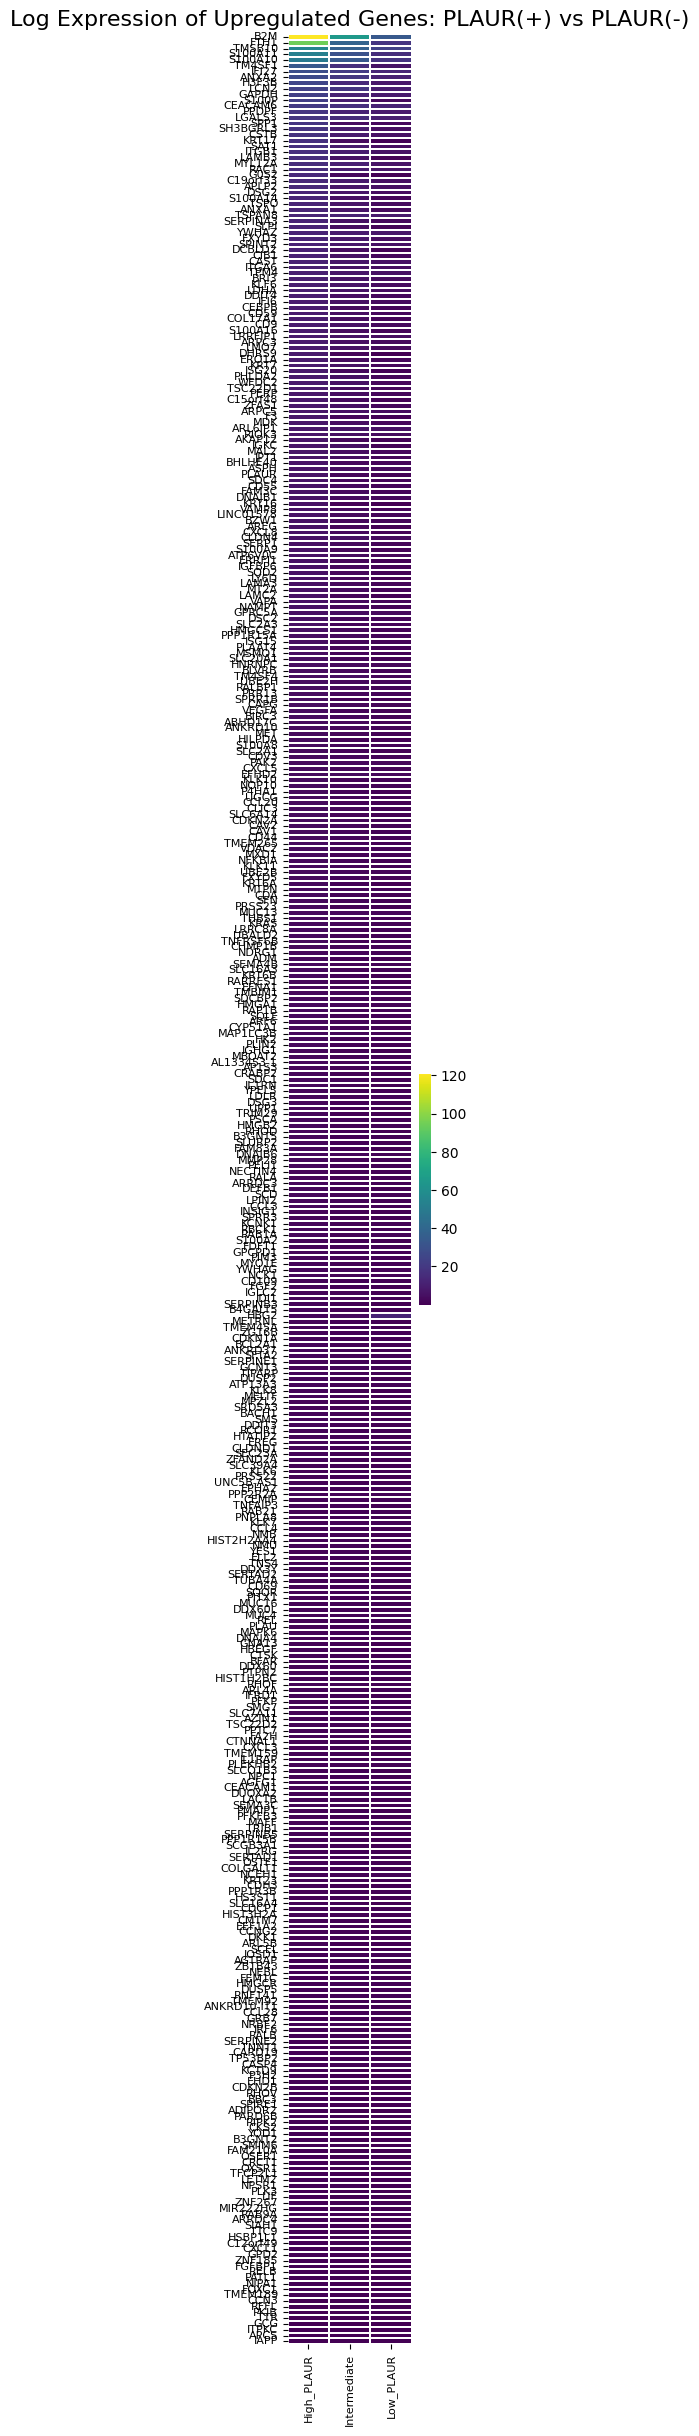

In [60]:
# Set up the figure with specified size
plt.figure(figsize=(2, 30))

# Create the heatmap for the mean expression of sorted genes
sns.heatmap(
    mean_expression.T.loc[sorted_genes],    # Use the sorted genes
    cmap='viridis',                         # Colormap for expression intensity
    annot=False,                            # Disable annotations on the heatmap
    cbar=True,                              # Display the color bar
    linewidths=0.25,                        # Thin lines between cells for clarity
    cbar_kws={"shrink": 0.1},               # Shrink the color bar for a more compact look
    yticklabels=1                           # Display gene labels with size adjustment
)

# Set the title and remove x/y axis labels
plt.title('Log Expression of Upregulated Genes: PLAUR(+) vs PLAUR(-)', fontsize=16)
plt.xlabel('')
plt.ylabel('')

# Adjust font sizes for gene labels on y-axis and status labels on x-axis
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

# Display the heatmap
plt.show()

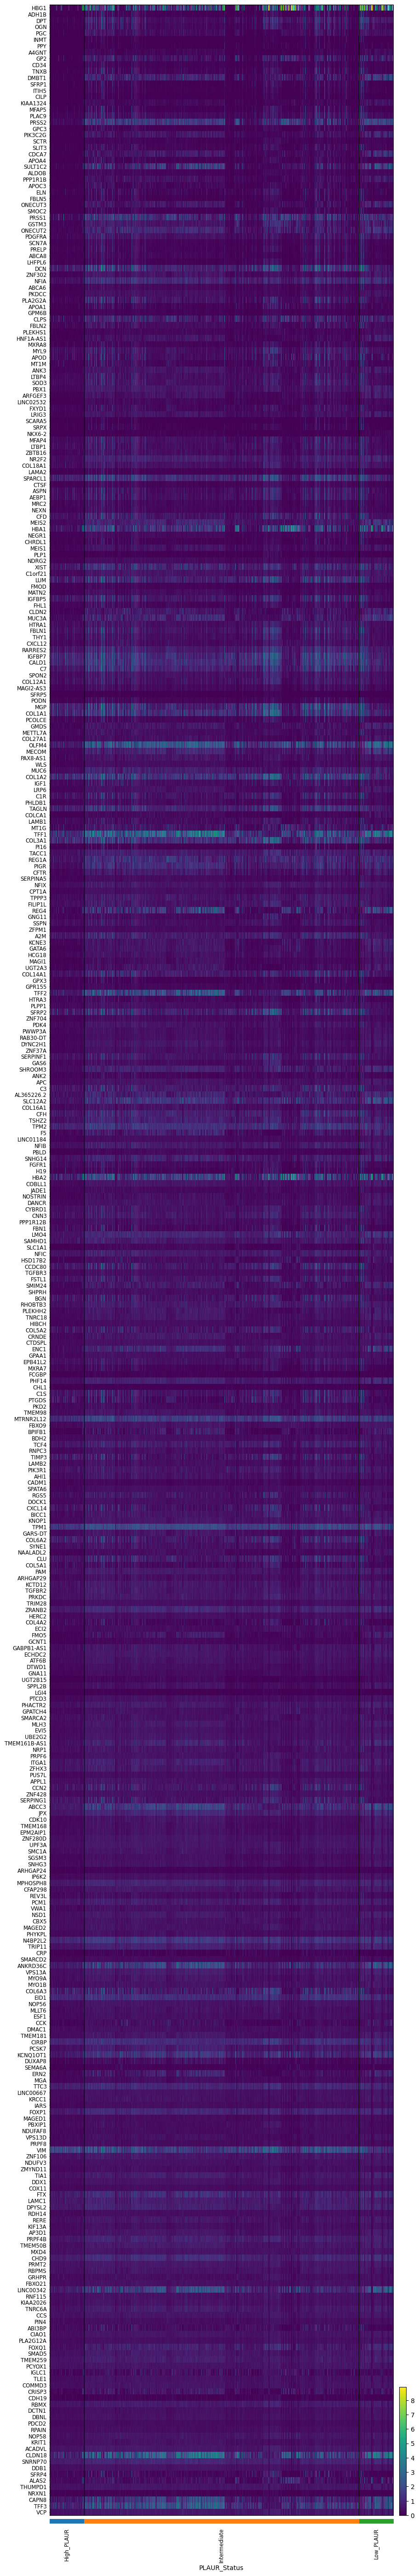

In [61]:
# Plot a heatmap of significant downregulated genes across PLAUR_Status groups
sc.pl.heatmap(
    epithelial_cells, 
    var_names=significant_genesPLAUR_down,  # List of downregulated genes to plot
    groupby='PLAUR_Status',                 # Group cells by PLAUR_Status
    swap_axes=True,                         # Display genes on the y-axis for better readability
    layer='scvi_normalized',                # Use SCVI-normalized layer for expression values
    log=True,                               # Log-transform values for clearer visualization
    show_gene_labels=True                   # Show gene labels on the heatmap
)


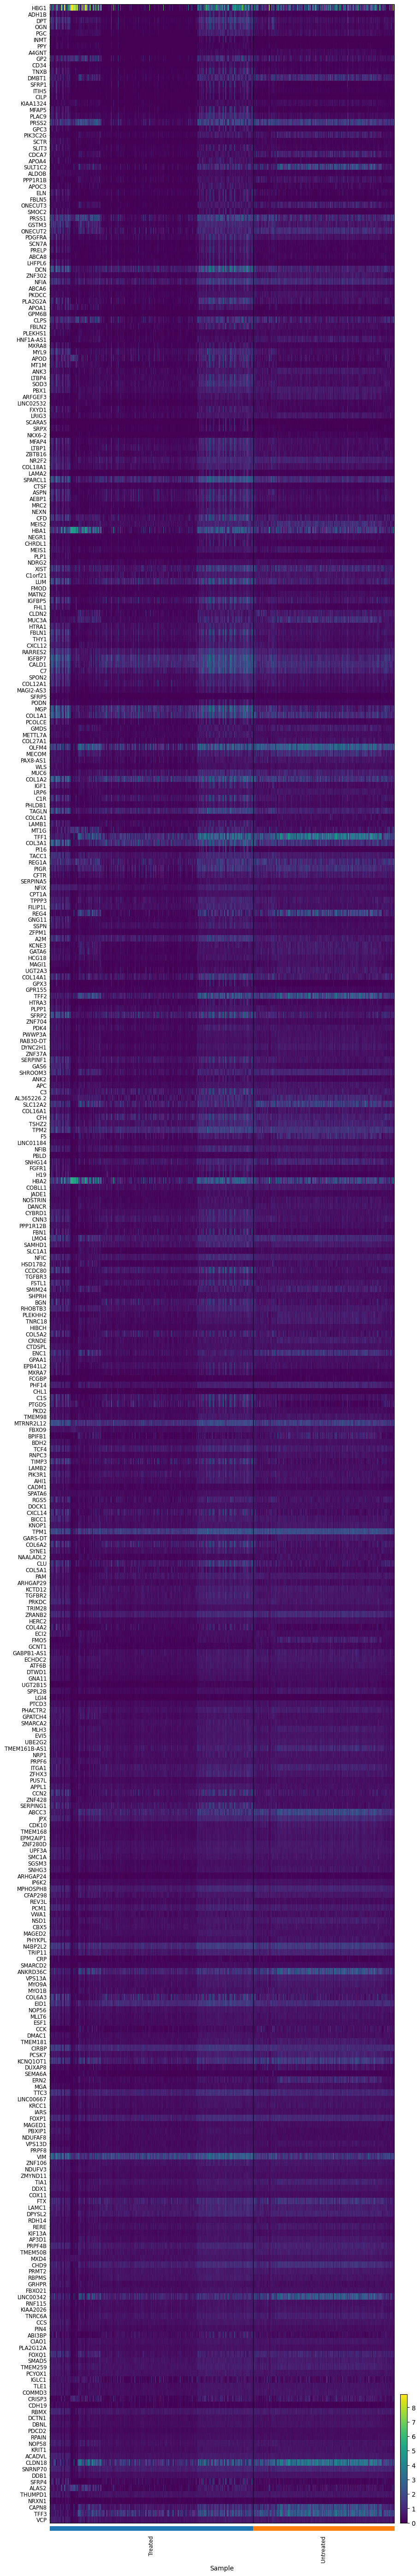

In [62]:
# Plot a heatmap of significant downregulated genes across samples grouped by the 'Sample' attribute
sc.pl.heatmap(
    epithelial_cells, 
    var_names=significant_genesPLAUR_down,  # List of downregulated genes to plot
    groupby='Sample',                       # Group cells by the 'Sample' attribute
    swap_axes=True,                         # Display genes on the y-axis for better readability
    layer='scvi_normalized',                # Use SCVI-normalized layer for expression values
    log=True,                               # Log-transform values for clearer visualization
    show_gene_labels=True                   # Show gene labels on the heatmap
)


In [63]:
# Define the gene list based on downregulated genes in PLAUR
gene_list = significant_genesPLAUR_down  # Replace with your actual gene list

# Filter the gene list to include only genes present in the dataset
available_genes = [gene for gene in gene_list if gene in epithelial_cells.var_names]


In [64]:
# Extract the scVI normalized expression values for available genes
expression_data = epithelial_cells[:, available_genes].to_df(layer='scvi_normalized')


In [65]:
# Add the PLAUR_Status labels to the expression data DataFrame
expression_data['PLAUR_Status'] = epithelial_cells.obs['PLAUR_Status'].values


In [66]:
# Calculate the mean expression of each gene for each PLAUR_Status group
mean_expression = expression_data.groupby('PLAUR_Status', observed=False).mean()


In [67]:
# Sort genes based on mean expression in the 'PLAUR-' group
sorted_genes = mean_expression.T.sort_values(by='Low_PLAUR', ascending=False).index


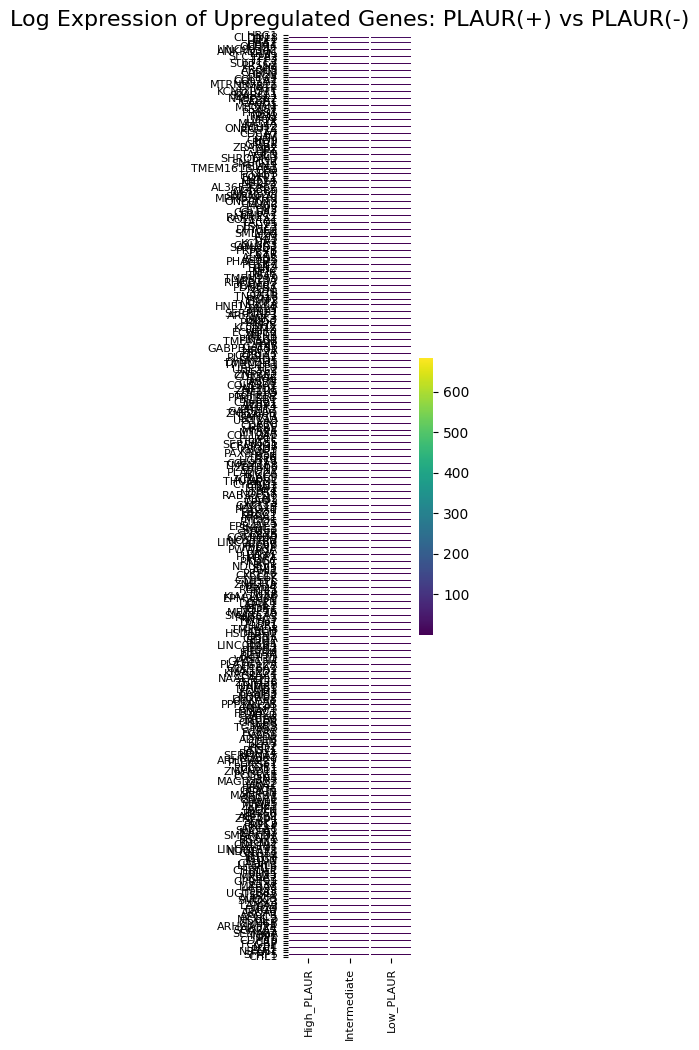

In [68]:
# Set up the figure size for the heatmap
plt.figure(figsize=(2, 12))

# Plot the heatmap for the mean expression of sorted genes
sns.heatmap(
    mean_expression.T.loc[sorted_genes],  # Use the sorted genes based on PLAUR- expression
    cmap='viridis',                       # Colormap for expression intensity
    annot=False,                          # Disable annotations on the heatmap
    cbar=True,                            # Show the color bar
    linewidths=0.25,                      # Thin lines between cells for clarity
    cbar_kws={"shrink": 0.3},             # Shrink the color bar for a compact look
    yticklabels=1                         # Display gene labels
)

# Add a title and remove x/y axis labels
plt.title('Log Expression of Upregulated Genes: PLAUR(+) vs PLAUR(-)', fontsize=16)
plt.xlabel('')
plt.ylabel('')

# Adjust font sizes for gene labels on y-axis and status labels on x-axis
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

# Display the heatmap
plt.show()

In [69]:
# Define a list of key genes associated with EMT (Epithelial-Mesenchymal Transition)
emt_gene_set = [
    'CDH1', 'VIM', 'SNAI1', 'SNAI2', 'ZEB1', 'ZEB2', 'TWIST1', 'FN1',
    'CDH2', 'MMP2', 'MMP9', 'ITGB1', 'ITGA5', 'CDH2', 'FOXC2', 'GSC'
]


In [70]:
# Calculate an EMT score for each cell using the EMT gene set
sc.tl.score_genes(epithelial_cells, gene_list=emt_gene_set, score_name='EMT_Score', use_raw=False)


In [71]:
# Subset cells based on PLAUR status
plaured_positive_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'High_PLAUR']
plaured_negative_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'Low_PLAUR']


In [72]:
# Calculate average EMT score for PLAUR+ and PLAUR- groups
avg_emt_score_positive = plaured_positive_cells.obs['EMT_Score'].mean()
avg_emt_score_negative = plaured_negative_cells.obs['EMT_Score'].mean()


In [73]:
# Print the average EMT scores for PLAUR+ and PLAUR- cells
print(f"Average EMT Score for PLAUR+ cells: {avg_emt_score_positive:.3f}")
print(f"Average EMT Score for PLAUR- cells: {avg_emt_score_negative:.3f}")


Average EMT Score for PLAUR+ cells: 0.230
Average EMT Score for PLAUR- cells: 0.030


<Figure size 1000x600 with 0 Axes>

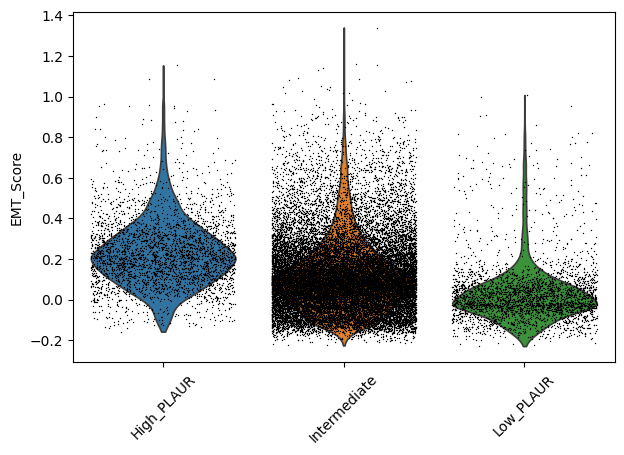

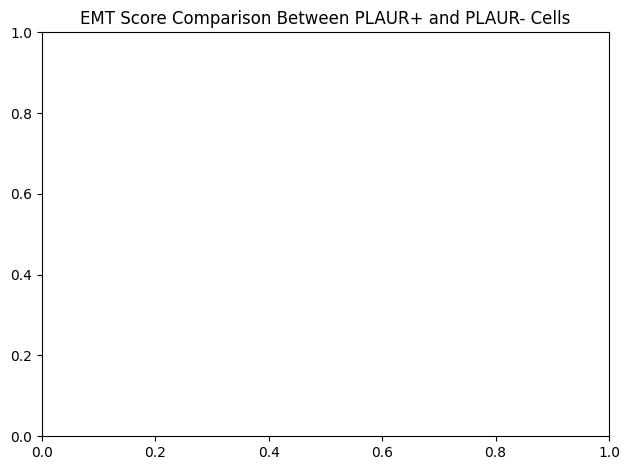

In [74]:
# Create a violin plot to visualize EMT score distributions across PLAUR groups
plt.figure(figsize=(10, 6))
sc.pl.violin(epithelial_cells, keys='EMT_Score', groupby='PLAUR_Status', jitter=0.4, rotation=45, show=True)
plt.title('EMT Score Comparison Between PLAUR+ and PLAUR- Cells')
plt.tight_layout()
plt.show()

In [75]:
# Verify the unique values in the PLAUR_Status column
print("Unique values in 'PLAUR_Status':", epithelial_cells.obs['PLAUR_Status'].unique())

# Check the number of cells labeled as PLAUR+ and PLAUR-
plaur_status_counts = epithelial_cells.obs['PLAUR_Status'].value_counts()
print("\nCount of cells labeled as PLAUR+ and PLAUR-:")
print(plaur_status_counts)


Unique values in 'PLAUR_Status': ['Intermediate', 'Low_PLAUR', 'High_PLAUR']
Categories (3, object): ['High_PLAUR', 'Intermediate', 'Low_PLAUR']

Count of cells labeled as PLAUR+ and PLAUR-:
PLAUR_Status
Intermediate    26054
High_PLAUR       3257
Low_PLAUR        3257
Name: count, dtype: int64


In [76]:
# Extract cells labeled as PLAUR+ and PLAUR- based on the 'PLAUR_Status' column
plaured_positive_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'High_PLAUR']
plaured_negative_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'Low_PLAUR']

# Verify that there are cells in both groups and raise an error if any group is empty
if plaured_positive_cells.shape[0] == 0:
    raise ValueError("No cells labeled as PLAUR+ after filtering.")
if plaured_negative_cells.shape[0] == 0:
    raise ValueError("No cells labeled as PLAUR- after filtering.")

# Print the number of cells in each PLAUR group
print(f"Number of PLAUR+ cells: {plaured_positive_cells.shape[0]}")
print(f"Number of PLAUR- cells: {plaured_negative_cells.shape[0]}")


Number of PLAUR+ cells: 3257
Number of PLAUR- cells: 3257


In [77]:
# Define the EMT gene set
emt_gene_set = [
    'CDH1', 'VIM', 'SNAI1', 'SNAI2', 'ZEB1', 'ZEB2', 'TWIST1', 'FN1',
    'CDH2', 'MMP2', 'MMP9', 'ITGB1', 'ITGA5', 'FOXC2', 'GSC'
]

# Convert genes to uppercase to ensure consistency with dataset identifiers
emt_gene_set_upper = [gene.upper() for gene in emt_gene_set]

# Filter EMT genes to include only those present in epithelial_cells
available_emt_genes = [gene for gene in emt_gene_set_upper if gene in epithelial_cells.var_names]


In [78]:
# Verify that there are available genes in the dataset for EMT scoring
if len(available_emt_genes) == 0:
    raise ValueError("None of the EMT genes are available. Please ensure your gene list matches the dataset's gene identifiers.")

# Recalculate EMT score using only the available genes
sc.tl.score_genes(epithelial_cells, gene_list=available_emt_genes, score_name='EMT_Score', use_raw=False)


In [79]:
# Check for NaN values in EMT_Score column and filter them out if any are found
emt_score_nan_count = epithelial_cells.obs['EMT_Score'].isna().sum()
if emt_score_nan_count > 0:
    print(f"Warning: {emt_score_nan_count} cells have NaN EMT scores. Filtering out these cells.")
    epithelial_cells = epithelial_cells[~epithelial_cells.obs['EMT_Score'].isna()]

print("EMT Score calculation complete and NaN values removed if present.")


EMT Score calculation complete and NaN values removed if present.


In [80]:
# Calculate the average EMT score for PLAUR+ and PLAUR- cells
avg_emt_score_positive = plaured_positive_cells.obs['EMT_Score'].mean()
avg_emt_score_negative = plaured_negative_cells.obs['EMT_Score'].mean()

# Print the results with formatted output
print(f"Average EMT Score for PLAUR+ cells: {avg_emt_score_positive:.3f}")
print(f"Average EMT Score for PLAUR- cells: {avg_emt_score_negative:.3f}")


Average EMT Score for PLAUR+ cells: 0.230
Average EMT Score for PLAUR- cells: 0.030


In [81]:
# Extract EMT scores for PLAUR+ and PLAUR- cells
emt_scores_positive = plaured_positive_cells.obs['EMT_Score']
emt_scores_negative = plaured_negative_cells.obs['EMT_Score']

# Perform Mann-Whitney U test to compare EMT scores between PLAUR+ and PLAUR- cells
if len(emt_scores_positive) > 0 and len(emt_scores_negative) > 0:
    u_stat, p_value = mannwhitneyu(emt_scores_positive, emt_scores_negative, alternative='two-sided')
    print(f"U-statistic: {u_stat:.3f}, p-value: {p_value:.3e}")
else:
    raise ValueError("One or both EMT score groups are empty, unable to perform statistical test.")

U-statistic: 9168838.000, p-value: 0.000e+00


<Figure size 1000x600 with 0 Axes>

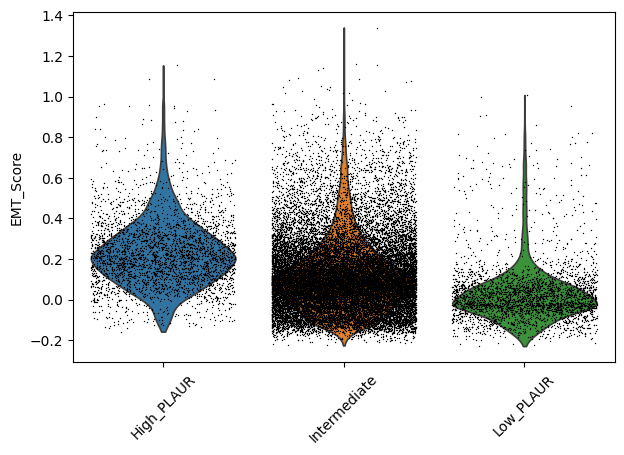

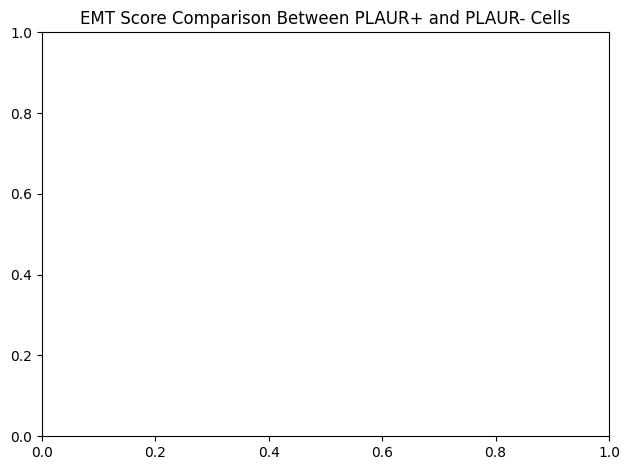

In [82]:
# Set up figure size
plt.figure(figsize=(10, 6))

# Plot a violin plot of EMT scores grouped by PLAUR_Status
sc.pl.violin(
    epithelial_cells, 
    keys='EMT_Score',        # Plot EMT_Score distribution
    groupby='PLAUR_Status',   # Group by PLAUR_Status (e.g., PLAUR+ and PLAUR-)
    jitter=0.4,               # Add jitter to the points for better visibility
    rotation=45,              # Rotate x-axis labels for readability
    show=True
)

# Add title and adjust layout for clarity
plt.title('EMT Score Comparison Between PLAUR+ and PLAUR- Cells')
plt.tight_layout()
plt.show()

/var/folders/d1/z52n225j7jl7n5v2t5tb35n80000gn/T/ipykernel_15200/2134530233.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


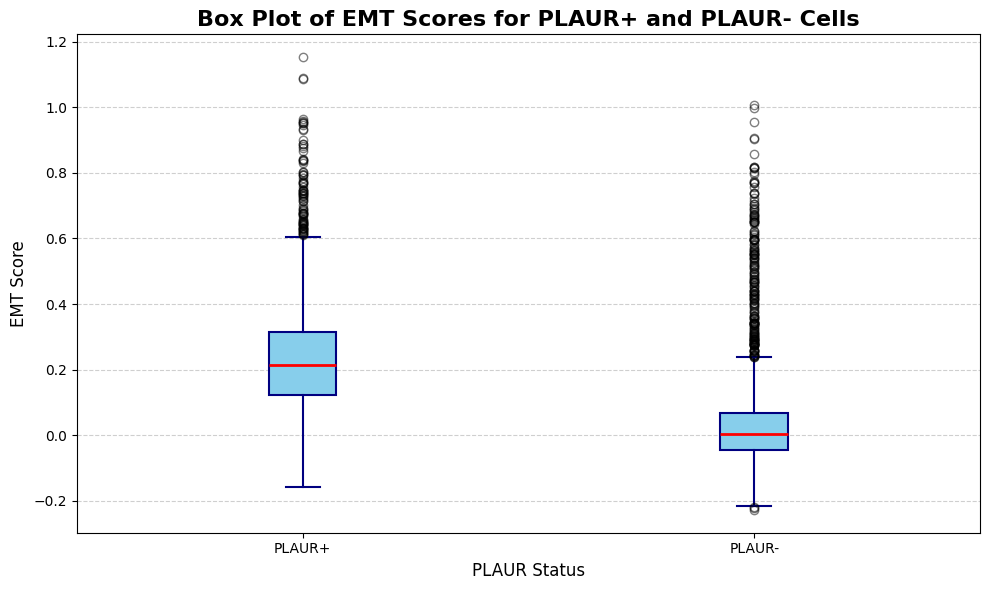

In [83]:
# Set up figure size
plt.figure(figsize=(10, 6))

# Create a customized box plot for EMT scores in PLAUR+ and PLAUR- cells
plt.boxplot(
    [emt_scores_positive, emt_scores_negative],
    labels=['PLAUR+', 'PLAUR-'],
    patch_artist=True,  # Fill boxes with color
    boxprops=dict(facecolor='skyblue', color='navy', linewidth=1.5),  # Box color and outline
    medianprops=dict(color='red', linewidth=2),  # Median line color and width
    whiskerprops=dict(color='navy', linewidth=1.5),  # Whisker color and width
    capprops=dict(color='navy', linewidth=1.5),  # Cap color and width
    flierprops=dict(marker='o', color='darkred', alpha=0.5)  # Outlier marker and style
)

# Set y-axis and x-axis labels
plt.ylabel('EMT Score', fontsize=12)
plt.xlabel('PLAUR Status', fontsize=12)

# Add a title with bold font weight
plt.title('Box Plot of EMT Scores for PLAUR+ and PLAUR- Cells', fontsize=16, fontweight='bold')

# Add a grid to the y-axis for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout for a cleaner look
plt.tight_layout()

# Display the plot
plt.show()

In [84]:
# Define the TP53 gene set associated with TP53 signaling pathway
tp53_gene_set = [
    'TP53', 'MDM2', 'CDKN1A', 'BAX', 'GADD45A', 'BBC3', 'PMAIP1', 'FAS',
    'RRM2B', 'TP53I3', 'SFN'
]

# Verify and filter genes to include only those present in epithelial_cells
available_tp53_genes = [gene.upper() for gene in tp53_gene_set if gene.upper() in epithelial_cells.var_names]


In [85]:
# Calculate the TP53 score for each cell using available genes in the TP53 pathway
sc.tl.score_genes(epithelial_cells, gene_list=available_tp53_genes, score_name='TP53_Score', use_raw=False)


In [86]:
# Extract cells labeled as PLAUR+ and PLAUR- based on 'PLAUR_Status'
plaured_positive_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'High_PLAUR']
plaured_negative_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'Low_PLAUR']


In [87]:
# Extract TP53 scores for PLAUR+ and PLAUR- cells
tp53_scores_positive = plaured_positive_cells.obs['TP53_Score']
tp53_scores_negative = plaured_negative_cells.obs['TP53_Score']

# Calculate the average TP53 score for each group
avg_tp53_score_positive = tp53_scores_positive.mean()
avg_tp53_score_negative = tp53_scores_negative.mean()

# Print average TP53 scores for comparison
print(f"Average TP53 Score for PLAUR+ cells: {avg_tp53_score_positive:.3f}")
print(f"Average TP53 Score for PLAUR- cells: {avg_tp53_score_negative:.3f}")


Average TP53 Score for PLAUR+ cells: -0.028
Average TP53 Score for PLAUR- cells: -0.141


In [88]:
# Perform Mann-Whitney U test to compare TP53 scores between PLAUR+ and PLAUR- cells
u_stat, p_value = mannwhitneyu(tp53_scores_positive, tp53_scores_negative, alternative='two-sided')
print(f"U-statistic: {u_stat:.3f}, p-value: {p_value:.3e}")

U-statistic: 7142448.000, p-value: 1.218e-129


<Figure size 1000x600 with 0 Axes>

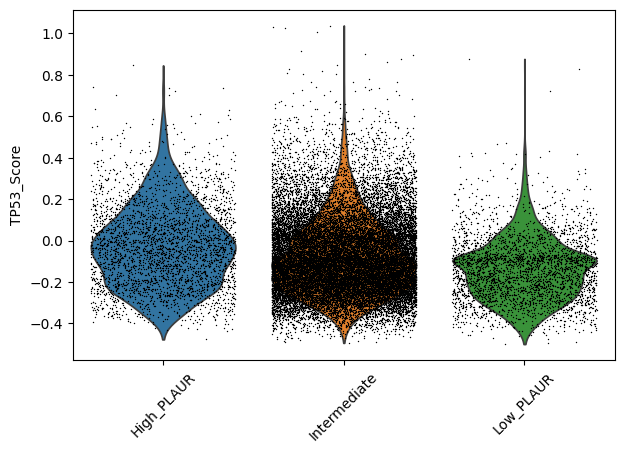

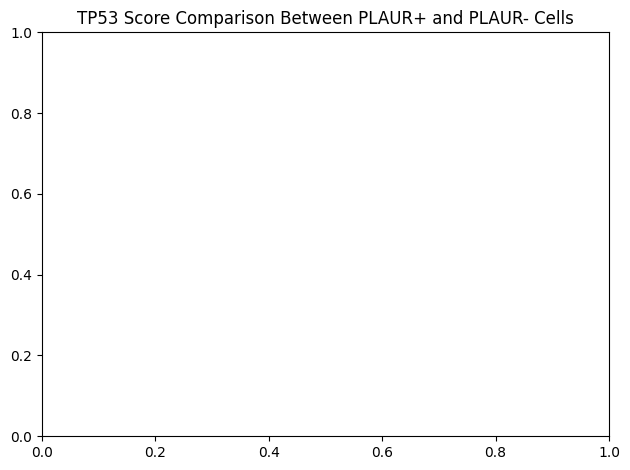

In [89]:
# Create a violin plot to visualize TP53 score distributions across PLAUR groups
plt.figure(figsize=(10, 6))
sc.pl.violin(epithelial_cells, keys='TP53_Score', groupby='PLAUR_Status', jitter=0.4, rotation=45, show=True)
plt.title('TP53 Score Comparison Between PLAUR+ and PLAUR- Cells')
plt.tight_layout()
plt.show()

/var/folders/d1/z52n225j7jl7n5v2t5tb35n80000gn/T/ipykernel_15200/3657835432.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


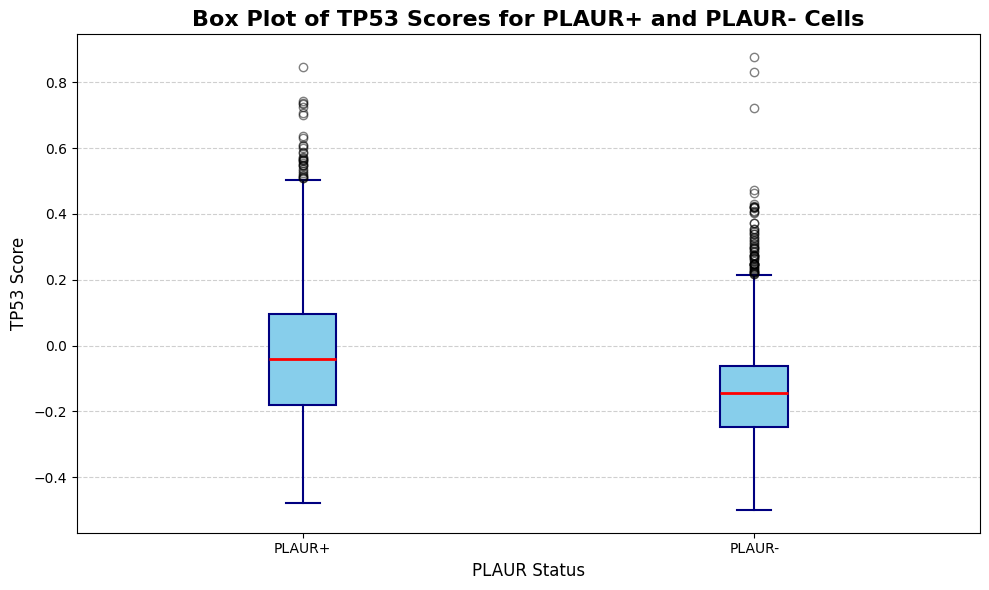

In [90]:
# Set up figure size
plt.figure(figsize=(10, 6))

# Create a customized box plot for TP53 scores in PLAUR+ and PLAUR- cells
plt.boxplot(
    [tp53_scores_positive, tp53_scores_negative],
    labels=['PLAUR+', 'PLAUR-'],
    patch_artist=True,  # Fill boxes with color
    boxprops=dict(facecolor='skyblue', color='navy', linewidth=1.5),  # Box color and outline
    medianprops=dict(color='red', linewidth=2),  # Median line color and width
    whiskerprops=dict(color='navy', linewidth=1.5),  # Whisker color and width
    capprops=dict(color='navy', linewidth=1.5),  # Cap color and width
    flierprops=dict(marker='o', color='darkred', alpha=0.5)  # Outlier marker style
)

# Set y-axis and x-axis labels
plt.ylabel('TP53 Score', fontsize=12)
plt.xlabel('PLAUR Status', fontsize=12)

# Add a title with bold font weight
plt.title('Box Plot of TP53 Scores for PLAUR+ and PLAUR- Cells', fontsize=16, fontweight='bold')

# Add a grid to the y-axis for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout for a cleaner look
plt.tight_layout()

# Display the plot
plt.show()

In [91]:
# Define a gene set associated with Basal cell markers
basal_gene_set = [
    'VGLL1', 'UCA1', 'S100A2', 'LY6D', 'SPRR3', 'SPRR1B', 'LEMD1', 'KRT15', 'CTSV', 'DHRS9', 'AREG',
    'CST6', 'SERPINB3', 'KRT6A', 'SERPINB4', 'FAM83A', 'SCEL', 'FGFBP1', 'KRT7', 'KRT17', 'GPR87', 'TNS4',
    'SLC2A1', 'ANXA8L1'
]


In [92]:
# Calculate the Basal score for each cell based on the defined gene set
sc.tl.score_genes(epithelial_cells, gene_list=basal_gene_set, score_name='Basal_Score', use_raw=False)


In [93]:
# Subset cells labeled as PLAUR+ and PLAUR- based on 'PLAUR_Status'
plaured_positive_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'High_PLAUR']
plaured_negative_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'Low_PLAUR']


In [94]:
# Calculate average Basal score for each group
avg_basal_score_positive = plaured_positive_cells.obs['Basal_Score'].mean()
avg_basal_score_negative = plaured_negative_cells.obs['Basal_Score'].mean()

# Print average Basal scores for comparison
print(f"Average Basal Score for PLAUR+ cells: {avg_basal_score_positive:.3f}")
print(f"Average Basal Score for PLAUR- cells: {avg_basal_score_negative:.3f}")


Average Basal Score for PLAUR+ cells: 0.355
Average Basal Score for PLAUR- cells: -0.145


<Figure size 1000x600 with 0 Axes>

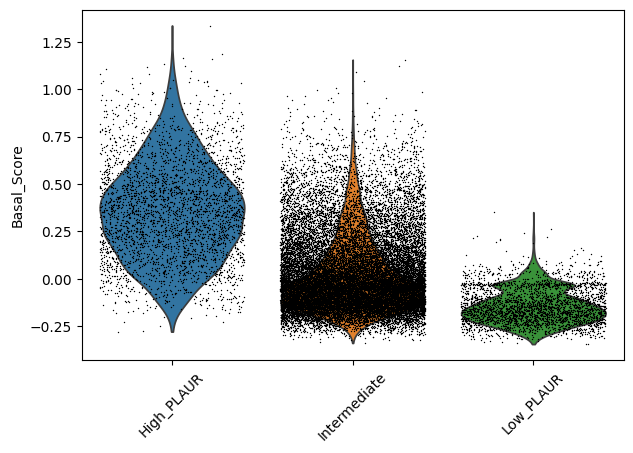

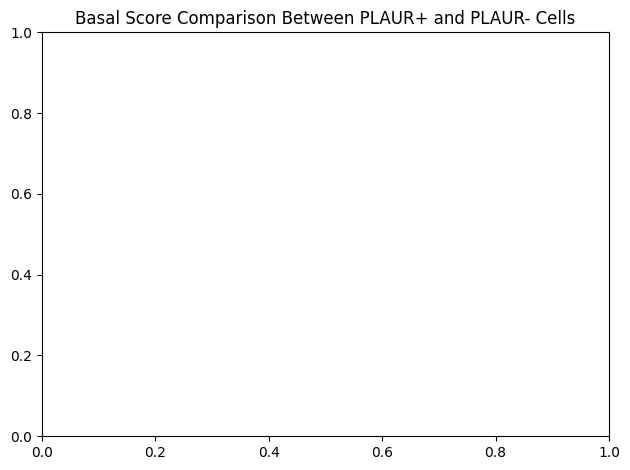

In [95]:
# Create a violin plot to visualize Basal score distributions across PLAUR groups
plt.figure(figsize=(10, 6))
sc.pl.violin(
    epithelial_cells, 
    keys='Basal_Score', 
    groupby='PLAUR_Status', 
    jitter=0.4, 
    rotation=45, 
    show=True
)
plt.title('Basal Score Comparison Between PLAUR+ and PLAUR- Cells')
plt.tight_layout()
plt.show()


In [96]:
# Extract Basal scores for PLAUR+ and PLAUR- cells
basal_scores_positive = plaured_positive_cells.obs['Basal_Score']
basal_scores_negative = plaured_negative_cells.obs['Basal_Score']

# Perform Mann-Whitney U test to compare Basal scores between PLAUR+ and PLAUR- cells
if len(basal_scores_positive) > 0 and len(basal_scores_negative) > 0:
    u_stat, p_value = mannwhitneyu(basal_scores_positive, basal_scores_negative, alternative='two-sided')
    print(f"U-statistic: {u_stat:.3f}, p-value: {p_value:.3e}")
else:
    raise ValueError("One or both Basal score groups are empty, unable to perform statistical test.")

U-statistic: 10370658.000, p-value: 0.000e+00


/var/folders/d1/z52n225j7jl7n5v2t5tb35n80000gn/T/ipykernel_15200/2689068119.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


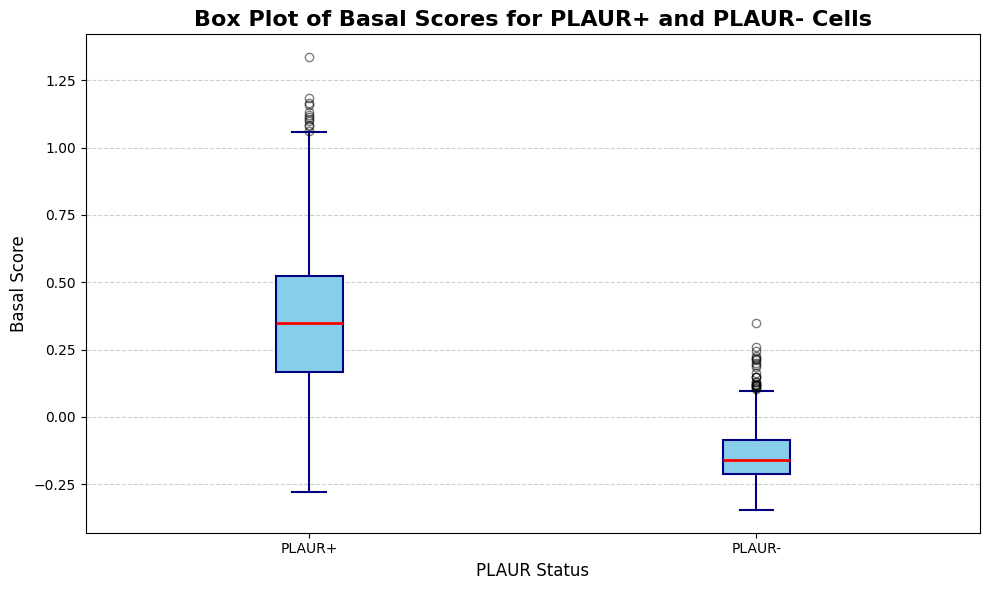

In [97]:
# Set up figure size
plt.figure(figsize=(10, 6))

# Create a customized box plot for Basal scores in PLAUR+ and PLAUR- cells
plt.boxplot(
    [basal_scores_positive, basal_scores_negative],
    labels=['PLAUR+', 'PLAUR-'],
    patch_artist=True,  # Fill boxes with color
    boxprops=dict(facecolor='skyblue', color='navy', linewidth=1.5),  # Box color and outline
    medianprops=dict(color='red', linewidth=2),  # Median line color and width
    whiskerprops=dict(color='navy', linewidth=1.5),  # Whisker color and width
    capprops=dict(color='navy', linewidth=1.5),  # Cap color and width
    flierprops=dict(marker='o', color='darkred', alpha=0.5)  # Outlier marker style
)

# Set y-axis and x-axis labels
plt.ylabel('Basal Score', fontsize=12)
plt.xlabel('PLAUR Status', fontsize=12)

# Add a title with bold font weight
plt.title('Box Plot of Basal Scores for PLAUR+ and PLAUR- Cells', fontsize=16, fontweight='bold')

# Add a grid to the y-axis for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout for a cleaner look
plt.tight_layout()

# Display the plot
plt.show()

In [98]:
# Define S phase and G2/M phase gene sets for cell cycle scoring
s_genes = [
    'MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2',
    'MCM6', 'CDCA7', 'DUT', 'MCM3', 'POLD3', 'WDR76', 'SLBP', 'CCNE2', 'UHRF1',
    'MSH2', 'RAD51', 'RRM2', 'CDC45', 'EXO1', 'TIPIN', 'DSCC1', 'BLM',
    'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1'
]

g2m_genes = [
    'HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80',
    'CCNA2', 'G2E3', 'HMMR', 'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'RANGAP1',
    'NCAPG', 'CDCA3', 'KIF20B', 'HMGB3', 'NUSAP1', 'NEK2', 'CENPF', 'TACC3',
    'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11',
    'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTNNB1', 'CDC20B'
]


In [99]:
# Filter S phase genes to include only those in var_names
s_genes_filtered = [gene for gene in s_genes if gene in epithelial_cells.var_names]

# Filter G2/M phase genes to include only those in var_names
g2m_genes_filtered = [gene for gene in g2m_genes if gene in epithelial_cells.var_names]


In [100]:
# Score the cell cycle phases using the filtered gene sets
sc.tl.score_genes_cell_cycle(epithelial_cells, s_genes=s_genes_filtered, g2m_genes=g2m_genes_filtered)


In [101]:
# Display the first few rows of the 'phase' column to verify phase assignment
print(epithelial_cells.obs[['phase']].head())


                   phase
AAACCCACAGACAAGC-1   G2M
AAACGAAGTCGTTTCC-1    G1
AAACGAATCCCAGGCA-1    G1
AAACGAATCTTTCGAT-1   G2M
AAACGCTAGACTCTAC-1   G2M


In [102]:
# Subset cells labeled as PLAUR+ and PLAUR- based on the 'PLAUR_Status' column in epithelial_cells
plaured_positive_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'High_PLAUR']
plaured_negative_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'Low_PLAUR']


In [103]:
# Count the number of cells in each cell cycle phase for PLAUR+ and PLAUR- groups
phase_counts_positive = plaured_positive_cells.obs['phase'].value_counts()
phase_counts_negative = plaured_negative_cells.obs['phase'].value_counts()


In [104]:
# Combine the phase counts into a DataFrame and fill missing values with 0
phase_counts_df = pd.DataFrame({
    'PLAUR+': phase_counts_positive,
    'PLAUR-': phase_counts_negative
}).fillna(0)


<Figure size 1000x600 with 0 Axes>

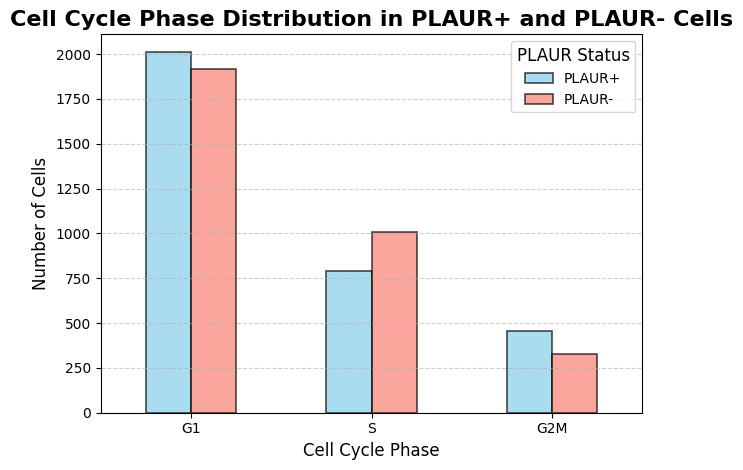

In [105]:
# Set up the figure for the bar plot
plt.figure(figsize=(10, 6))

# Plot the cell cycle phase distribution as a bar plot
phase_counts_df.plot(
    kind='bar', 
    color=['skyblue', 'salmon'],  # Colors for PLAUR+ and PLAUR- bars
    alpha=0.7, 
    edgecolor='black', 
    linewidth=1.2
)

# Set labels, title, and other visual settings
plt.xlabel('Cell Cycle Phase', fontsize=12)
plt.ylabel('Number of Cells', fontsize=12)
plt.title('Cell Cycle Phase Distribution in PLAUR+ and PLAUR- Cells', fontsize=16, fontweight='bold')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.6)  # Add a grid to the y-axis for readability
plt.tight_layout()  # Adjust layout for a clean look
plt.legend(title='PLAUR Status', fontsize=10, title_fontsize=12)

# Show the plot
plt.show()

To determine if there is a statistically significant difference in the cell cycle phase distribution between **PLAUR+** and **PLAUR-** cells, a Chi-square test for independence is suitable. This test assesses whether there is an association between two categorical variables—in this case, **cell cycle phase** and **PLAUR status**. Below are the steps to perform this analysis:

1. **Calculate the Observed Counts**: Obtain the counts of cells in each cell cycle phase for both **PLAUR+** and **PLAUR-** groups.
2. **Create a Contingency Table**: Construct a contingency table with cell cycle phases as rows and PLAUR statuses (PLAUR+ and PLAUR-) as columns.
3. **Perform the Chi-square Test**: Use the Chi-square test for independence on the contingency table to determine if there is a significant association between **cell cycle phase** and **PLAUR status**.
4. **Interpret the Results**: A significant p-value (typically < 0.05) would indicate that the distribution of cell cycle phases differs between **PLAUR+** and **PLAUR-** cells, suggesting a potential association between PLAUR status and cell cycle phase distribution.

In [106]:
# Create a contingency table of cell cycle phase counts for PLAUR+ and PLAUR- cells
contingency_table = pd.crosstab(epithelial_cells.obs['phase'], epithelial_cells.obs['PLAUR_Status'])

# Display the contingency table
print("Contingency Table:")
print(contingency_table)

Contingency Table:
PLAUR_Status  High_PLAUR  Intermediate  Low_PLAUR
phase                                            
G1                  2010         15418       1917
G2M                  457          3663        330
S                    790          6973       1010


In [107]:
# Perform Chi-square test for independence on the contingency table
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("\nChi-square Test Results:")
print(f"Chi-square Statistic: {chi2_stat:.3f}")
print(f"P-value: {p_value:.3e}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies Table:")
print(expected)


Chi-square Test Results:
Chi-square Statistic: 65.394
P-value: 2.125e-13
Degrees of Freedom: 4
Expected Frequencies Table:
[[ 1934.61879759 15475.76240481  1934.61879759]
 [  445.02732744  3559.94534512   445.02732744]
 [  877.35387497  7018.29225006   877.35387497]]


### Step 3: Interpret the Results

The results of the Chi-square test provide several key statistics:

- **Chi-square Statistic (`chi2_stat`)**: Measures the extent to which observed cell counts differ from expected counts, assuming no association between **cell cycle phase** and **PLAUR status**. A larger statistic suggests a greater deviation from expected values, indicating a potential association.
  
- **P-value (`p_value`)**: Determines the statistical significance of the observed deviation. A p-value below 0.05 suggests that the association between cell cycle phase and PLAUR status is statistically significant, allowing us to reject the null hypothesis of independence.
  
- **Degrees of Freedom (`dof`)**: Indicates the number of independent values in the contingency table, accounting for its size and structure.
  
- **Expected Frequencies (`expected`)**: Represents the counts we would expect in each cell if there were no association between **cell cycle phase** and **PLAUR status**.

### Example Output Interpretation

- If the **p-value** is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant association between **cell cycle phase** and **PLAUR status**. This means the distribution of cell cycle phases differs significantly between **PLAUR+** and **PLAUR-** cells.
  
- If the **p-value** is greater than 0.05, we fail to reject the null hypothesis, suggesting no significant association between cell cycle phase and PLAUR status.

### Summary of Steps

1. **Create a Contingency Table**: Use `pandas.crosstab()` to summarize cell cycle phase counts for **PLAUR+** and **PLAUR-** groups.
2. **Perform the Chi-square Test**: Use `scipy.stats.chi2_contingency()` to conduct a Chi-square test for independence.
3. **Interpret the Results**: Based on the p-value, determine if there is a statistically significant difference in cell cycle phase distributions between **PLAUR+** and **PLAUR-** cells.


In [108]:
# Define a MAP Kinase gene set
mapk_gene_set = [
    'MAPK1', 'MAPK3', 'MAPK8', 'MAPK9', 'MAPK14',
    'RAF1', 'BRAF', 'MAP2K1', 'MAP2K2',
    'HRAS', 'KRAS', 'NRAS', 'DUSP1', 'DUSP6',
    'SOS1', 'GRB2', 'EGFR', 'FGFR1'
]

# Convert gene names to uppercase to ensure consistency with dataset identifiers
mapk_gene_set_upper = [gene.upper() for gene in mapk_gene_set]

# Filter to include only genes present in epithelial_cells
available_mapk_genes = [gene for gene in mapk_gene_set_upper if gene in epithelial_cells.var_names]


In [109]:
# Calculate the MAPK score for each cell based on the available genes
sc.tl.score_genes(epithelial_cells, gene_list=available_mapk_genes, score_name='MAPK_Score', use_raw=False)


In [110]:
# Check if the MAPK score was successfully added
print(epithelial_cells.obs[['MAPK_Score']].head())


                    MAPK_Score
AAACCCACAGACAAGC-1    0.099598
AAACGAAGTCGTTTCC-1    0.144515
AAACGAATCCCAGGCA-1   -0.019998
AAACGAATCTTTCGAT-1   -0.058627
AAACGCTAGACTCTAC-1   -0.039302


In [111]:
# Step 3: Extract cells labeled as PLAUR+ and PLAUR- based on 'PLAUR_Status' column in epithelial_cells
plaured_positive_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'High_PLAUR']
plaured_negative_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'Low_PLAUR']


/var/folders/d1/z52n225j7jl7n5v2t5tb35n80000gn/T/ipykernel_15200/325093929.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


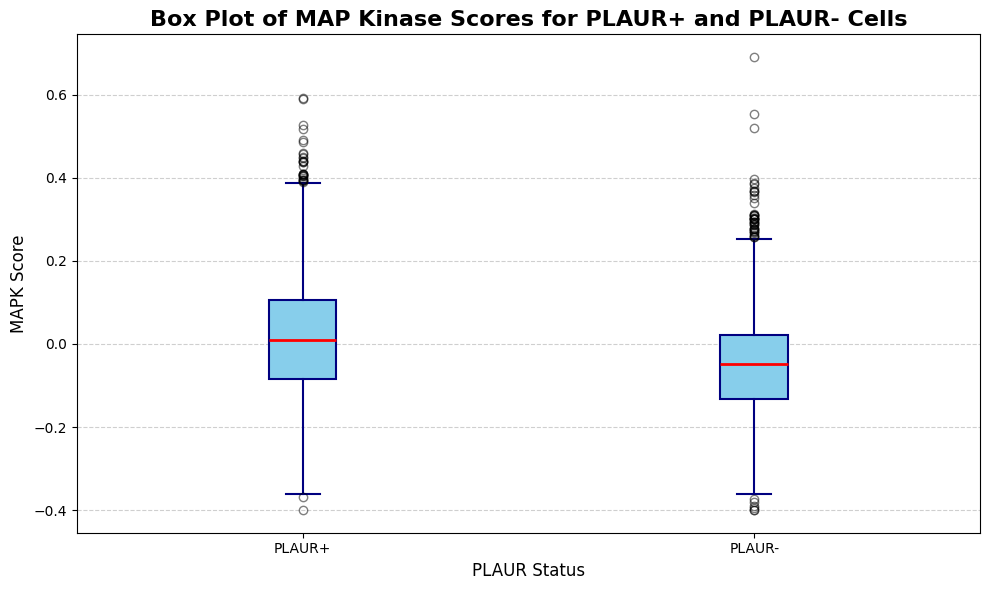

In [112]:
# Set up figure size
plt.figure(figsize=(10, 6))

# Create a customized box plot for MAPK scores in PLAUR+ and PLAUR- cells
plt.boxplot(
    [plaured_positive_cells.obs['MAPK_Score'], plaured_negative_cells.obs['MAPK_Score']],
    labels=['PLAUR+', 'PLAUR-'],
    patch_artist=True,  # Fill boxes with color
    boxprops=dict(facecolor='skyblue', color='navy', linewidth=1.5),  # Box color and outline
    medianprops=dict(color='red', linewidth=2),  # Median line color and width
    whiskerprops=dict(color='navy', linewidth=1.5),  # Whisker color and width
    capprops=dict(color='navy', linewidth=1.5),  # Cap color and width
    flierprops=dict(marker='o', color='darkred', alpha=0.5)  # Outlier marker style
)

# Set y-axis and x-axis labels
plt.ylabel('MAPK Score', fontsize=12)
plt.xlabel('PLAUR Status', fontsize=12)

# Add a title with bold font weight
plt.title('Box Plot of MAP Kinase Scores for PLAUR+ and PLAUR- Cells', fontsize=16, fontweight='bold')

# Add a grid to the y-axis for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout for a cleaner look
plt.tight_layout()

# Display the plot
plt.show()

/var/folders/d1/z52n225j7jl7n5v2t5tb35n80000gn/T/ipykernel_15200/2623118258.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


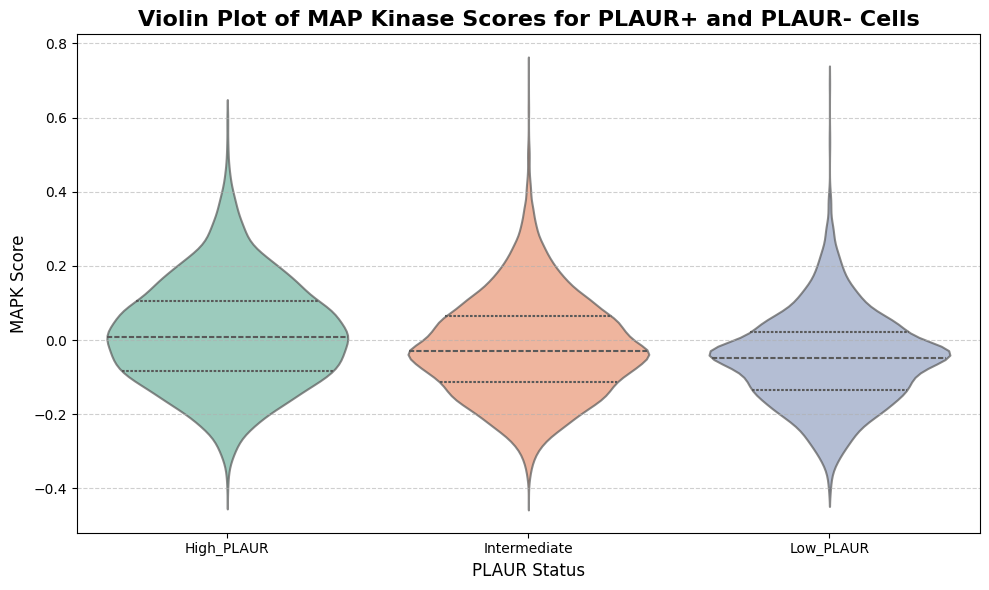

In [113]:
# Set up figure size
plt.figure(figsize=(10, 6))

# Create a violin plot for MAPK scores in PLAUR+ and PLAUR- cells
sns.violinplot(
    x='PLAUR_Status',          # Group by PLAUR Status (PLAUR+ and PLAUR-)
    y='MAPK_Score',             # MAPK Score values for each group
    data=epithelial_cells.obs,  # Data from epithelial_cells.obs
    palette='Set2',             # Color palette
    inner='quartile',           # Show inner quartiles within the violin plot
    linewidth=1.5,              # Line width for edges
    alpha=0.7                   # Transparency of violins
)

# Set x and y axis labels
plt.xlabel('PLAUR Status', fontsize=12)
plt.ylabel('MAPK Score', fontsize=12)

# Add a title with bold font weight
plt.title('Violin Plot of MAP Kinase Scores for PLAUR+ and PLAUR- Cells', fontsize=16, fontweight='bold')

# Add a grid to the y-axis for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout for a cleaner look
plt.tight_layout()

# Display the plot
plt.show()

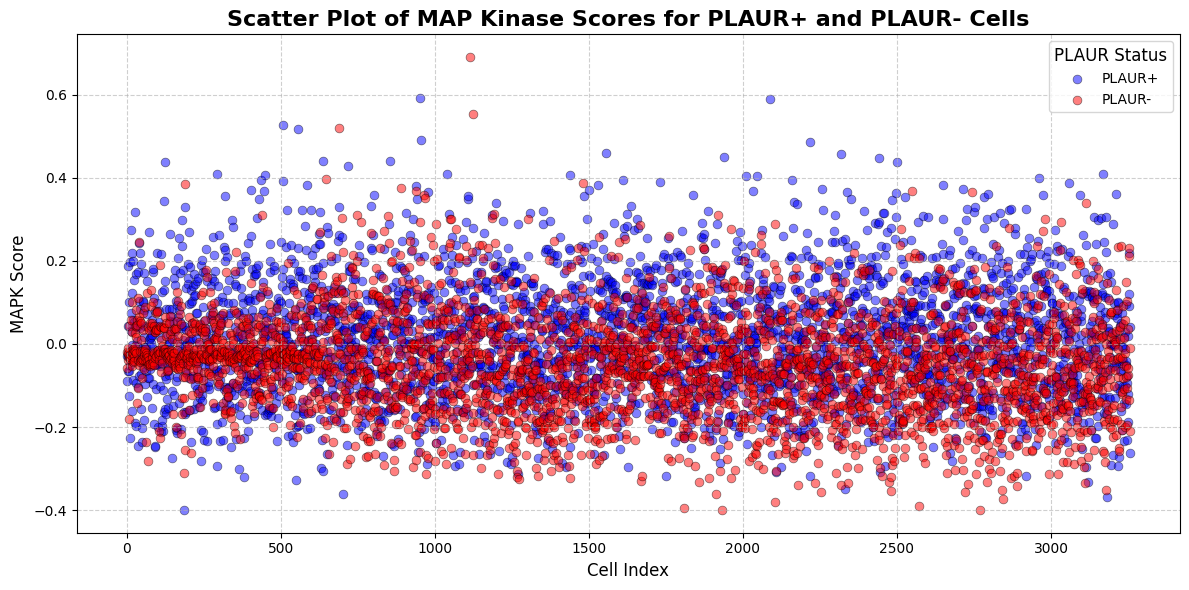

In [114]:
# Set up figure size
plt.figure(figsize=(12, 6))

# Scatter plot for MAPK scores of PLAUR+ cells
plt.scatter(
    range(len(plaured_positive_cells)),                  # X-axis: Cell index
    plaured_positive_cells.obs['MAPK_Score'],            # Y-axis: MAPK Score for PLAUR+ cells
    color='blue', alpha=0.5, edgecolor='black',          # Styling: blue color, black edge
    linewidth=0.5, label='PLAUR+', s=40                  # Label, size, and linewidth
)

# Scatter plot for MAPK scores of PLAUR- cells
plt.scatter(
    range(len(plaured_negative_cells)),                  # X-axis: Cell index
    plaured_negative_cells.obs['MAPK_Score'],            # Y-axis: MAPK Score for PLAUR- cells
    color='red', alpha=0.5, edgecolor='black',           # Styling: red color, black edge
    linewidth=0.5, label='PLAUR-', s=40                  # Label, size, and linewidth
)

# Set x and y axis labels
plt.xlabel('Cell Index', fontsize=12)
plt.ylabel('MAPK Score', fontsize=12)

# Add a title with bold font weight
plt.title('Scatter Plot of MAP Kinase Scores for PLAUR+ and PLAUR- Cells', fontsize=16, fontweight='bold')

# Add legend with title and adjusted font sizes
plt.legend(title='PLAUR Status', title_fontsize=12, fontsize=10)

# Add grid for readability
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust layout for a cleaner look
plt.tight_layout()

# Display the plot
plt.show()

In [115]:
# Define the Classical gene set
classical_gene_set = [
    'BTNL8', 'FAM3D', 'PRR15L', 'AGR3', 'CTSE', 'LYZ', 'TFF2', 'TFF1', 'ANXA10', 'LGALS4', 'PLA2G10', 'CEACAM6', 
    'VSIG2', 'TSPAN8', 'ST6GALNAC1', 'AGR2', 'TFF3', 'CYP3A7', 'MYO1A', 'CLRN3', 'KRT20', 'CDH17', 'SPINK4', 'REG4'
]

# Filter and retain only genes available in the dataset
available_classical_genes = [gene.upper() for gene in classical_gene_set if gene.upper() in epithelial_cells.var_names]


In [116]:
# Calculate the Classical score for each cell based on the available genes
sc.tl.score_genes(epithelial_cells, gene_list=available_classical_genes, score_name='Classical_Score', use_raw=False)


In [117]:
# Extract cells labeled as PLAUR+ and PLAUR- based on the 'PLAUR_Status' column in epithelial_cells
plaured_positive_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'High_PLAUR']
plaured_negative_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'Low_PLAUR']


In [118]:
# Extract Classical scores for PLAUR+ and PLAUR- cells
classical_scores_positive = plaured_positive_cells.obs['Classical_Score']
classical_scores_negative = plaured_negative_cells.obs['Classical_Score']

# Calculate the average Classical score for each group
avg_classical_score_positive = classical_scores_positive.mean()
avg_classical_score_negative = classical_scores_negative.mean()

# Print average Classical scores for comparison
print(f"Average Classical Score for PLAUR+ cells: {avg_classical_score_positive:.3f}")
print(f"Average Classical Score for PLAUR- cells: {avg_classical_score_negative:.3f}")


Average Classical Score for PLAUR+ cells: 0.363
Average Classical Score for PLAUR- cells: 0.661


In [119]:
# Perform Mann-Whitney U test to compare Classical scores between PLAUR+ and PLAUR- cells
u_stat, p_value = mannwhitneyu(classical_scores_positive, classical_scores_negative, alternative='two-sided')
print(f"U-statistic: {u_stat:.3f}, p-value: {p_value:.3e}")


U-statistic: 3079827.000, p-value: 8.158e-189


<Figure size 1000x600 with 0 Axes>

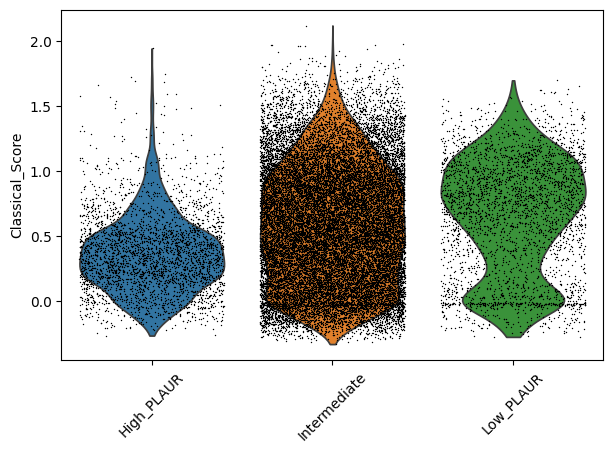

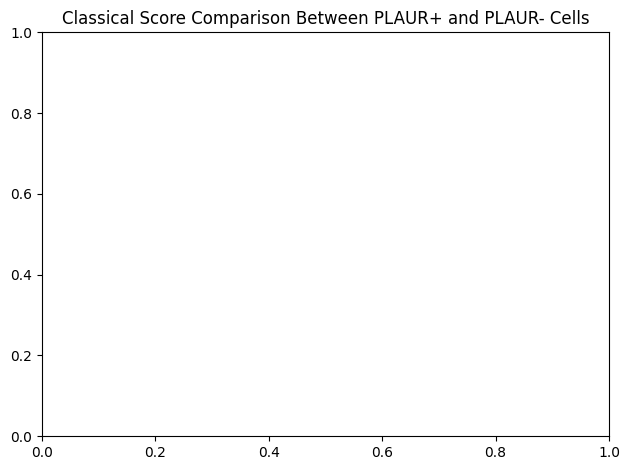

In [120]:
# Create a violin plot to visualize Classical score distributions across PLAUR groups
plt.figure(figsize=(10, 6))
sc.pl.violin(
    epithelial_cells, 
    keys='Classical_Score', 
    groupby='PLAUR_Status', 
    jitter=0.4, 
    rotation=45, 
    show=True
)
plt.title('Classical Score Comparison Between PLAUR+ and PLAUR- Cells')
plt.tight_layout()
plt.show()

/var/folders/d1/z52n225j7jl7n5v2t5tb35n80000gn/T/ipykernel_15200/1878799558.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


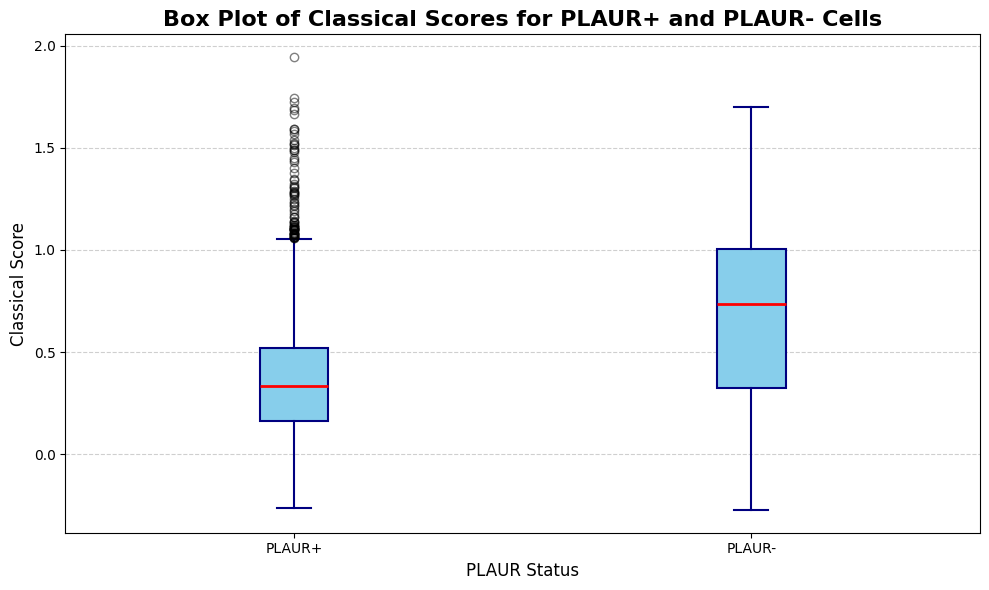

In [121]:
# Set up figure size
plt.figure(figsize=(10, 6))

# Create a customized box plot for Classical scores in PLAUR+ and PLAUR- cells
plt.boxplot(
    [classical_scores_positive, classical_scores_negative],
    labels=['PLAUR+', 'PLAUR-'],
    patch_artist=True,  # Fill boxes with color
    boxprops=dict(facecolor='skyblue', color='navy', linewidth=1.5),  # Box color and outline
    medianprops=dict(color='red', linewidth=2),  # Median line color and width
    whiskerprops=dict(color='navy', linewidth=1.5),  # Whisker color and width
    capprops=dict(color='navy', linewidth=1.5),  # Cap color and width
    flierprops=dict(marker='o', color='darkred', alpha=0.5)  # Outlier marker style
)

# Set y-axis and x-axis labels
plt.ylabel('Classical Score', fontsize=12)
plt.xlabel('PLAUR Status', fontsize=12)

# Add a title with bold font weight
plt.title('Box Plot of Classical Scores for PLAUR+ and PLAUR- Cells', fontsize=16, fontweight='bold')

# Add a grid to the y-axis for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout for a cleaner look
plt.tight_layout()

# Display the plot
plt.show()

In [122]:
# Define the CIN (Chromosomal Instability) gene set
cin_gene_set = [
    "EZH2", 'JUN', 'VIM', 'STEAP1', 'SOX4', 'MMP14', 'TIMP1', 
    'ZEB1', 'ITGB5', 'ITGB1', 'ITGA5', 'IGFBP4', 'FN1', 'DSC2', 
    'CXCL1', 'CTNNB1', 'BMP4', 'BCL2L1', 'KIF2A', 'SHH', 'KIF2C'
]

In [123]:
# Filter CIN genes to include only those available in epithelial_cells.var_names
# This ensures that only valid genes present in the dataset are used for scoring
available_cin_genes = [gene.upper() for gene in cin_gene_set if gene.upper() in epithelial_cells.var_names]

In [124]:
# Score the filtered CIN gene set in epithelial_cells
# 'score_genes' calculates an expression score based on the provided gene list
# 'CIN_Score' will be added as a new observation (obs) in the epithelial_cells dataset
sc.tl.score_genes(
    epithelial_cells,            # Dataset to score
    gene_list=available_cin_genes, # List of validated CIN genes
    score_name='CIN_Score',      # Name for the computed score
    use_raw=False                # Use processed data instead of raw
)

In [125]:
# Extract PLAUR+ and PLAUR- cells based on 'PLAUR_Status' in the dataset
# This filters the epithelial_cells dataset into two separate groups based on PLAUR expression status

# Subset of cells with positive PLAUR expression ('PLAUR+')
plaured_positive_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'High_PLAUR']

# Subset of cells with negative PLAUR expression ('PLAUR-')
plaured_negative_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'Low_PLAUR']

In [127]:
# Extract CIN scores for PLAUR+ and PLAUR- cells
# This isolates CIN scores based on PLAUR status to analyze the difference in score distributions
cin_scores_positive = plaured_positive_cells.obs['CIN_Score']
cin_scores_negative = plaured_negative_cells.obs['CIN_Score']


In [128]:
# Calculate the average CIN score for both PLAUR+ and PLAUR- cells
# Averages provide a quick comparison of central tendency between the two groups
avg_cin_score_positive = cin_scores_positive.mean()
avg_cin_score_negative = cin_scores_negative.mean()

In [129]:
# Print average CIN scores for each group with formatting for clarity
print(f"Average CIN Score for PLAUR+ cells: {avg_cin_score_positive:.3f}")
print(f"Average CIN Score for PLAUR- cells: {avg_cin_score_negative:.3f}")

Average CIN Score for PLAUR+ cells: 0.336
Average CIN Score for PLAUR- cells: 0.191


In [130]:
# Perform Mann-Whitney U test to compare CIN score distributions between PLAUR+ and PLAUR- cells
# This non-parametric test checks for significant differences without assuming normal distribution
u_stat, p_value = mannwhitneyu(cin_scores_positive, cin_scores_negative, alternative='two-sided')
print(f"U-statistic: {u_stat:.3f}, p-value: {p_value:.3e}")

U-statistic: 7898678.000, p-value: 3.443e-256


<Figure size 1000x600 with 0 Axes>

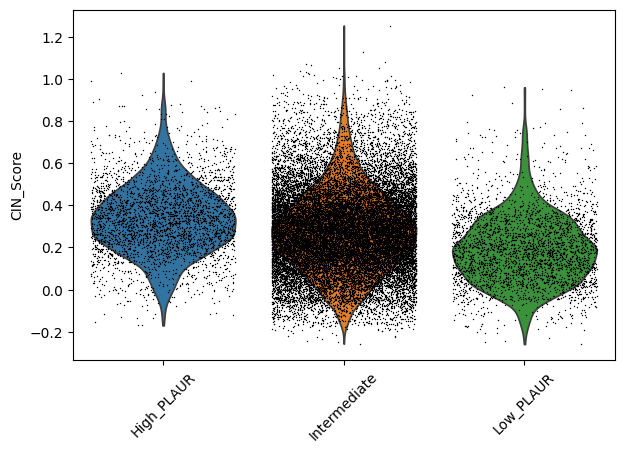

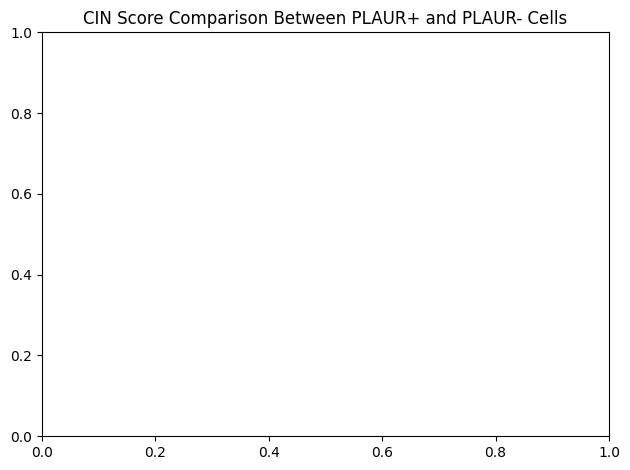

In [131]:
# Visualize the CIN score distribution between PLAUR+ and PLAUR- cells
plt.figure(figsize=(10, 6))
sc.pl.violin(
    epithelial_cells,            # Original dataset to visualize CIN score distribution
    keys='CIN_Score',            # Key indicating the CIN score to plot
    groupby='PLAUR_Status',      # Group data by PLAUR status (PLAUR+ vs PLAUR-)
    jitter=0.4,                  # Adds slight jitter for better visualization
    rotation=45,                 # Rotates x-axis labels for readability
    show=True
)
plt.title('CIN Score Comparison Between PLAUR+ and PLAUR- Cells')
plt.tight_layout()
plt.show()

/var/folders/d1/z52n225j7jl7n5v2t5tb35n80000gn/T/ipykernel_15200/3845023486.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


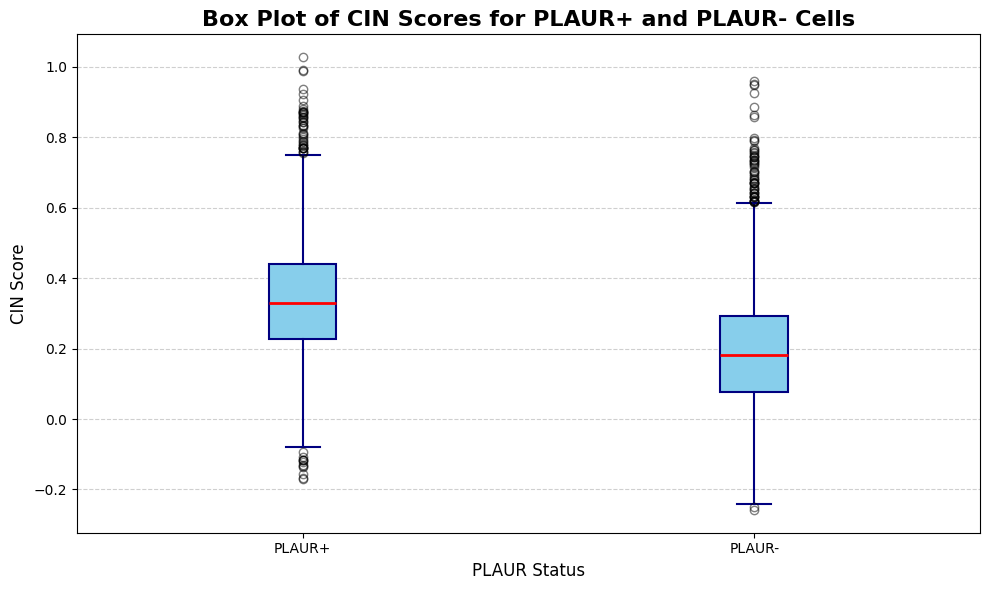

In [132]:
plt.figure(figsize=(10, 6))

# Creating the box plot with custom styling
plt.boxplot(
    [cin_scores_positive, cin_scores_negative],   # Data for PLAUR+ and PLAUR- CIN scores
    labels=['PLAUR+', 'PLAUR-'],                  # Labels for each group
    patch_artist=True,                            # Enables custom color filling
    boxprops=dict(facecolor='skyblue', color='navy', linewidth=1.5),     # Box appearance
    medianprops=dict(color='red', linewidth=2),                         # Median line style
    whiskerprops=dict(color='navy', linewidth=1.5),                     # Whisker appearance
    capprops=dict(color='navy', linewidth=1.5),                         # Cap appearance
    flierprops=dict(marker='o', color='darkred', alpha=0.5)             # Outlier appearance
)

# Labeling the axes for clarity
plt.ylabel('CIN Score', fontsize=12)
plt.xlabel('PLAUR Status', fontsize=12)

# Title for the plot with enhanced formatting
plt.title('Box Plot of CIN Scores for PLAUR+ and PLAUR- Cells', fontsize=16, fontweight='bold')

# Adding a grid for better readability of values, styled lightly for non-intrusiveness
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()